In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
from datetime import timedelta
%load_ext line_profiler
sns.set(style="darkgrid")
import requests
import pprint
import re
%matplotlib inline

In [2]:
time1 = datetime.now()
# df = pd.read_csv('../flight_data.csv')
p = 0.10  # p% of lines
filename = '../flight_data.csv'
random.seed(234)

# if random from [0,1] > p, skip row
df = pd.read_csv(
         filename,
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)
time2 = datetime.now()
print('Time cost: ', time2-time1)

C:\Users\abrea\.julia\packages\Conda\hsaaN\deps\usr\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Time cost:  0:00:24.499555


In [3]:
airport_lst = ['TKI']
tail_num_lst = ['PLANET', 'N101NK', 'N999FR', 'N700TA', 'N187SW', 'N399FR']
df = df[(~df['ORIGIN'].isin(airport_lst)) & (~df['TAIL_NUM'].isin(tail_num_lst))]
df = df[(df['ORIGIN'] != 'TKI') & (df['TAIL_NUM'] != 'PLANET') & (df['TAIL_NUM'] != 'N101NK') & (df['TAIL_NUM'] != 'N999FR') & (df['TAIL_NUM'] != 'N700TA') & (df['TAIL_NUM'] != 'N187SW') & (df['TAIL_NUM'] != 'N399FR')]

In [4]:
time1 = datetime.now()
airport_lst = ['TKI']
tail_num_lst = ['PLANET', 'N101NK', 'N999FR', 'N700TA', 'N187SW', 'N399FR']
df = df[(~df['ORIGIN'].isin(airport_lst)) & (~df['TAIL_NUM'].isin(tail_num_lst))]

wban_iata = pd.read_csv('../../Weather Data/wban_to_iata.csv')
weather = pd.read_csv('../../Weather Data/data/weather_pre.csv', parse_dates=['DATE'])

weather['WBAN'] = weather['STATION'].apply(lambda x: int(x[5:]))

time2 = datetime.now()
print('Time cost: ', time2-time1)

C:\Users\abrea\.julia\packages\Conda\hsaaN\deps\usr\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,19,20,23,24,25,26,27,28,29,33,34,37,38,39,40,44,45,46,47,48,49,50,59,60,61,62,63,64,67,68,69,71,72,73,74,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Time cost:  0:02:34.578407


In [5]:
# For delayed flights
delayed_flight = df[df['DEP_DELAY'] > 15].reset_index(drop=True)
df_flight_time = pd.DataFrame()
df_flight_time['date'] = delayed_flight['FL_DATE']
df_flight_time['time'] = delayed_flight['CRS_DEP_TIME']
df_flight_time['origin'] = delayed_flight['ORIGIN']
df_flight_time['delay'] = delayed_flight['DEP_DELAY']
df_flight_time['time'] = df_flight_time['time'].apply(lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00' if x >= 100 else '00:'+str(x)+':00')
df_flight_time['datetime'] = df_flight_time['date'].map(str) + '/' + df_flight_time['time']
df_flight_time['datetime'] = pd.to_datetime(df_flight_time['datetime'], format='%Y-%m-%d/%H:%M:%S')
df_flight_time = df_flight_time.merge(wban_iata, left_on='origin', right_on='IATA', how='inner').drop(columns=['origin'])

In [7]:
df[['CRS_DEP_TIME', 'CRS_ARR_TIME']]

CRS_DEP_TIME  CRS_ARR_TIME
0                1435          1648
1                1100          1224
2                1420          1845
3                1030          1146
4                2100          2217
5                1800          1954
6                1513          1842
7                1520          1808
8                1105          1643
9                1742          1929
10                945          1135
11               2010          2119
12               1930          2359
13                604           855
14               1459          1604
15               1700          1824
16               1145          1340
17               1400          1647
18                905          1103
19               1500          1610
20               1300          1453
21               1600          1836
22               1116          1305
23               2321            42
24               1451          1914
25               1248          1405
26               1445          1615
27               2207          2347
28                830          1201
29               1651          1748
...               ...           ...
1129274          1720          2333
1129275          1435          1722
1129276          2020          2149
1129277          1405          1644
1129278          1045          1135
1129279           925          1200
1129280          1757          2118
1129281          1238          1505
1129282           702           835
1129283          1605          1925
1129284          1433          1528
1129285           740          1110
1129286          1320          1455
1129287          2025          2324
1129288           652           810
1129289          1050          1931
1129290          1540          1911
1129291          1755          2159
1129292          1005          1329
1129293           608           908
1129294          2108          2230
1129295          1947          2112
1129296          2110          2358
1129297          1105          1933
1129298          2055          2353
1129299          1538          2040
1129300          1915          2040
1129301          1545          1710
1129302          2145          2242
1129303          1710          1944

[1129295 rows x 2 columns]

In [6]:
df['dep_time'] = df['CRS_DEP_TIME'].apply(lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00' if x >= 100 else '00:'+str(x)+':00')
df['dep_datetime'] = df['FL_DATE'].map(str) + '/' + df['dep_time']
df['dep_datetime'] = pd.to_datetime(df['dep_datetime'], format='%Y-%m-%d/%H:%M:%S')
df['arr_time'] = df['CRS_ARR_TIME'].apply(lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00' if x >= 100 else '00:'+str(x)+':00')
df['arr_datetime'] = df['FL_DATE'].map(str) + '/' + df['arr_time']
# np.where(df['arr_datetime']=='2016-06-01/24:00:00')
# df['arr_datetime'][3464631] = '2016-06-02/00:00:00'
df['arr_datetime'] = pd.to_datetime(df['arr_datetime'], format='%Y-%m-%d/%H:%M:%S')

In [8]:
df.describe()

YEAR       QUARTER         MONTH  DAY_OF_MONTH   DAY_OF_WEEK  \
count  1.129295e+06  1.129295e+06  1.129295e+06  1.129295e+06  1.129295e+06   
mean   2.016503e+03  2.513306e+00  6.539739e+00  1.576398e+01  3.938053e+00   
std    4.999938e-01  1.104894e+00  3.397235e+00  8.779171e+00  1.988428e+00   
min    2.016000e+03  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%    2.016000e+03  2.000000e+00  4.000000e+00  8.000000e+00  2.000000e+00   
50%    2.017000e+03  3.000000e+00  7.000000e+00  1.600000e+01  4.000000e+00   
75%    2.017000e+03  3.000000e+00  9.000000e+00  2.300000e+01  6.000000e+00   
max    2.017000e+03  4.000000e+00  1.200000e+01  3.100000e+01  7.000000e+00   

       OP_CARRIER_AIRLINE_ID  OP_CARRIER_FL_NUM  ORIGIN_AIRPORT_ID  \
count           1.129295e+06       1.129295e+06       1.129295e+06   
mean            1.990055e+04       2.111942e+03       1.269180e+04   
std             3.804945e+02       1.720234e+03       1.534987e+03   
min             1.939300e+04       1.000000e+00       1.013500e+04   
25%             1.979000e+04       7.240000e+02       1.129200e+04   
50%             1.980500e+04       1.662000e+03       1.289200e+04   
75%             2.030400e+04       2.964000e+03       1.405700e+04   
max             2.117100e+04       8.402000e+03       1.621800e+04   

       ORIGIN_AIRPORT_SEQ_ID  ORIGIN_CITY_MARKET_ID      ...       \
count           1.129295e+06           1.129295e+06      ...        
mean            1.269183e+06           3.172559e+04      ...        
std             1.534984e+05           1.279872e+03      ...        
min             1.013503e+06           3.007000e+04      ...        
25%             1.129202e+06           3.064700e+04      ...        
50%             1.289203e+06           3.145300e+04      ...        
75%             1.405702e+06           3.246700e+04      ...        
max             1.621801e+06           3.599100e+04      ...        

       DIV4_TAIL_NUM  DIV5_AIRPORT  DIV5_AIRPORT_ID  DIV5_AIRPORT_SEQ_ID  \
count            0.0           0.0              0.0                  0.0   
mean             NaN           NaN              NaN                  NaN   
std              NaN           NaN              NaN                  NaN   
min              NaN           NaN              NaN                  NaN   
25%              NaN           NaN              NaN                  NaN   
50%              NaN           NaN              NaN                  NaN   
75%              NaN           NaN              NaN                  NaN   
max              NaN           NaN              NaN                  NaN   

       DIV5_WHEELS_ON  DIV5_TOTAL_GTIME  DIV5_LONGEST_GTIME  DIV5_WHEELS_OFF  \
count             0.0               0.0                 0.0              0.0   
mean              NaN               NaN                 NaN              NaN   
std               NaN               NaN                 NaN              NaN   
min               NaN               NaN                 NaN              NaN   
25%               NaN               NaN                 NaN              NaN   
50%               NaN               NaN                 NaN              NaN   
75%               NaN               NaN                 NaN              NaN   
max               NaN               NaN                 NaN              NaN   

       DIV5_TAIL_NUM  Unnamed: 109  
count            0.0           0.0  
mean             NaN           NaN  
std              NaN           NaN  
min              NaN           NaN  
25%              NaN           NaN  
50%              NaN           NaN  
75%              NaN           NaN  
max              NaN           NaN  

[8 rows x 91 columns]

In [9]:
# add 1 day for flights overnight
df.arr_datetime = df[['CRS_DEP_TIME', 'CRS_ARR_TIME', 'arr_datetime']].apply(
lambda x: x[2] + timedelta(days=1) if x[0] - x[1] >= 600 else x[2] , axis=1)

In [11]:
df.loc[0, 'DEST']

'ATL'

In [10]:
df = df.merge(wban_iata, left_on='ORIGIN', right_on='IATA', how='inner').drop(columns=['IATA']).rename(columns={'WBAN':'origin_WBAN'})
df = df.merge(wban_iata, left_on='DEST', right_on='IATA', how='inner').drop(columns=['IATA']).rename(columns={'WBAN':'dest_WBAN'})

In [12]:
df.head()

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK     FL_DATE  \
0  2016        1      1             1            5  2016-01-01   
1  2016        1      1             3            7  2016-01-03   
2  2016        1      1             4            1  2016-01-04   
3  2016        1      1             6            3  2016-01-06   
4  2016        1      1             5            2  2016-01-05   

  OP_UNIQUE_CARRIER  OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM    ...      \
0                DL                  19790         DL   N905DA    ...       
1                DL                  19790         DL   N659DL    ...       
2                DL                  19790         DL   N973DL    ...       
3                DL                  19790         DL   N940DL    ...       
4                DL                  19790         DL   N914DN    ...       

   DIV5_LONGEST_GTIME  DIV5_WHEELS_OFF  DIV5_TAIL_NUM  Unnamed: 109  dep_time  \
0                 NaN              NaN            NaN           NaN  14:35:00   
1                 NaN              NaN            NaN           NaN   6:00:00   
2                 NaN              NaN            NaN           NaN   7:00:00   
3                 NaN              NaN            NaN           NaN   9:17:00   
4                 NaN              NaN            NaN           NaN   7:25:00   

         dep_datetime  arr_time        arr_datetime origin_WBAN  dest_WBAN  
0 2016-01-01 14:35:00  16:48:00 2016-01-01 16:48:00       13899      13874  
1 2016-01-03 06:00:00   8:09:00 2016-01-03 08:09:00       13899      13874  
2 2016-01-04 07:00:00   9:14:00 2016-01-04 09:14:00       13899      13874  
3 2016-01-06 09:17:00  11:28:00 2016-01-06 11:28:00       13899      13874  
4 2016-01-05 07:25:00   9:38:00 2016-01-05 09:38:00       13899      13874  

[5 rows x 116 columns]

In [15]:
df.sort_values(by='origin_WBAN')

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK     FL_DATE  \
114638   2016        1      1            10            7  2016-01-10   
1036655  2017        2      4            14            5  2017-04-14   
130786   2017        2      4            15            6  2017-04-15   
130828   2017        2      4            16            7  2017-04-16   
1036771  2017        2      4            18            2  2017-04-18   
130946   2017        2      4            19            3  2017-04-19   
1036835  2017        2      4            20            4  2017-04-20   
131082   2017        2      4            22            6  2017-04-22   
131201   2017        2      4            25            2  2017-04-25   
1037049  2017        2      4            28            5  2017-04-28   
131374   2017        2      4            30            7  2017-04-30   
131400   2017        2      5             1            1  2017-05-01   
131478   2017        2      5             3            3  2017-05-03   
1037271  2017        2      5             6            6  2017-05-06   
1037448  2017        2      5            13            6  2017-05-13   
131958   2017        2      5            16            2  2017-05-16   
132172   2017        2      5            22            1  2017-05-22   
132201   2017        2      5            23            2  2017-05-23   
1036484  2017        2      4             8            6  2017-04-08   
132243   2017        2      5            24            3  2017-05-24   
1036228  2017        1      3            30            4  2017-03-30   
1036045  2017        1      3            23            4  2017-03-23   
1034171  2017        1      1             8            7  2017-01-08   
127185   2017        1      1             9            1  2017-01-09   
127282   2017        1      1            12            4  2017-01-12   
1034570  2017        1      1            24            2  2017-01-24   
127730   2017        1      1            25            3  2017-01-25   
1034761  2017        1      2             1            3  2017-02-01   
128098   2017        1      2             4            6  2017-02-04   
1034895  2017        1      2             6            1  2017-02-06   
...       ...      ...    ...           ...          ...         ...   
617813   2016        4     10            12            3  2016-10-12   
617858   2016        4     10            13            4  2016-10-13   
616722   2016        3      9            13            2  2016-09-13   
617999   2016        4     10            18            2  2016-10-18   
618760   2016        4     11             9            3  2016-11-09   
618815   2016        4     11            11            5  2016-11-11   
618929   2016        4     11            15            2  2016-11-15   
618999   2016        4     11            17            4  2016-11-17   
619207   2016        4     11            23            3  2016-11-23   
619385   2016        4     11            29            2  2016-11-29   
618079   2016        4     10            20            4  2016-10-20   
613505   2016        2      6            24            5  2016-06-24   
616694   2016        3      9            12            1  2016-09-12   
616461   2016        3      9             5            1  2016-09-05   
614055   2016        3      7             8            5  2016-07-08   
614128   2016        3      7            10            7  2016-07-10   
614146   2016        3      7            10            7  2016-07-10   
614337   2016        3      7            14            4  2016-07-14   
614358   2016        3      7            15            5  2016-07-15   
614522   2016        3      7            19            2  2016-07-19   
616598   2016        3      9             9            5  2016-09-09   
614561   2016        3      7            20            3  2016-07-20   
614881   2016        3      7            28            4  2016-07-28   
615087   2016        3      8             2      

In [31]:
df = df.sort_values(by=['origin_WBAN', 'dep_datetime'])

In [32]:
df1 = df

In [33]:
df1 = df1.sort_index()

In [34]:
def find_closest_date(lst):
    # takes a pd.Timestamp() instance and a pd.Series with dates in it
    # calcs the delta between `timepoint` and each date in `time_series`
    # returns the closest date and optionally
    # the number of days in its time delta
    global wban
    global weather_series
    global grouped
    if wban != lst[0]:
        weather_series = grouped.get_group(lst[0]).DATE
        wban = lst[0]
    else:
        pass
    timepoint = np.datetime64(lst[1])
    deltas = np.abs(np.subtract(weather_series.values, timepoint))
    idx_closest_date = np.argmin(deltas)
    return weather_series.index[idx_closest_date]


grouped = weather.groupby('WBAN')
weather_series = pd.Series()
time1 = datetime.now()
wban = -1
df1 = df1.sort_values(by=['origin_WBAN', 'dep_datetime']).reset_index(
    drop=True)
df1['origin_weather_index'] = df1[['origin_WBAN', 'dep_datetime']].apply(lambda x: find_closest_date(x), axis=1)
df1 = df1.sort_values(by=['dest_WBAN', 'arr_datetime']).reset_index(
    drop=True)
wban = -1
df1['dest_weather_index'] = df1[['dest_WBAN', 'arr_datetime']].apply(lambda x: find_closest_date(x), axis=1)

time2 = datetime.now()
print('Time cost: ', time2-time1)

Time cost:  0:06:46.828630


In [35]:
df = df1

In [36]:
df.head()

YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK     FL_DATE  \
0  2016        1      1             1            5  2016-01-01   
1  2016        1      1             2            6  2016-01-02   
2  2016        1      1             3            7  2016-01-03   
3  2016        1      1             9            6  2016-01-09   
4  2016        1      1             9            6  2016-01-09   

  OP_UNIQUE_CARRIER  OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM   ...     \
0                B6                  20409         B6   N593JB   ...      
1                B6                  20409         B6   N593JB   ...      
2                B6                  20409         B6   N187JB   ...      
3                B6                  20409         B6   N535JB   ...      
4                B6                  20409         B6   N190JB   ...      

   Unnamed: 109  dep_time        dep_datetime  arr_time        arr_datetime  \
0           NaN  23:59:00 2016-01-01 23:59:00   4:46:00 2016-01-02 04:46:00   
1           NaN  23:59:00 2016-01-02 23:59:00   4:46:00 2016-01-03 04:46:00   
2           NaN  23:35:00 2016-01-03 23:35:00   3:26:00 2016-01-04 03:26:00   
3           NaN  21:55:00 2016-01-09 21:55:00   1:49:00 2016-01-10 01:49:00   
4           NaN  23:56:00 2016-01-09 23:56:00   3:47:00 2016-01-10 03:47:00   

  origin_WBAN dest_WBAN  origin_weather_index dest_weather_index  new_col  
0       94789       398               2358721            3662713        0  
1       94789       398               2358754            3662718        0  
2       12815       398               7476524            3662724        0  
3       12815       398               7476759            3662786        0  
4       12815       398               7476761            3662788        0  

[5 rows x 119 columns]

In [37]:
df['dest_WBAN'].describe()

count    1.129295e+06
mean     2.824800e+04
std      2.917871e+04
min      3.980000e+02
25%      1.374100e+04
50%      1.481900e+04
75%      2.323400e+04
max      9.493800e+04
Name: dest_WBAN, dtype: float64

In [38]:
df['new_col'] = 0

In [39]:
df.groupby('origin_WBAN').first().new_col

origin_WBAN
398      0
3017     0
3102     0
3103     0
3145     0
3181     0
3802     0
3812     0
3816     0
3820     0
3822     0
3856     0
3870     0
3901     0
3902     0
3904     0
3927     0
3928     0
3935     0
3936     0
3937     0
3940     0
3945     0
3947     0
3950     0
3968     0
4724     0
4725     0
4781     0
4803     0
        ..
93874    0
93915    0
93989    0
94014    0
94023    0
94025    0
94161    0
94163    0
94178    0
94720    0
94724    0
94745    0
94746    0
94761    0
94789    0
94815    0
94823    0
94830    0
94836    0
94846    0
94847    0
94849    0
94853    0
94860    0
94890    0
94893    0
94910    0
94928    0
94931    0
94938    0
Name: new_col, Length: 320, dtype: int64

In [41]:
df['new_col'].unique()

array([0], dtype=int64)

In [40]:
def func2(df, weather, wban_iata):
    # time1 = datetime.now()
#     df['dep_time'] = df['CRS_DEP_TIME'].apply(lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00' if x >= 100 else '00:'+str(x)+':00')
#     df['dep_datetime'] = df['FL_DATE'].map(str) + '/' + df['dep_time']
#     df['dep_datetime'] = pd.to_datetime(df['dep_datetime'], format='%Y-%m-%d/%H:%M:%S')
#     df['arr_time'] = df['CRS_ARR_TIME'].apply(lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00' if x >= 100 else '00:'+str(x)+':00')
#     df['arr_datetime'] = df['FL_DATE'].map(str) + '/' + df['arr_time']
#     df['arr_datetime'] = pd.to_datetime(df['arr_datetime'], format='%Y-%m-%d/%H:%M:%S')

#     # add 1 day for flights overnight
#     df.arr_datetime = df[['CRS_DEP_TIME', 'CRS_ARR_TIME', 'arr_datetime']].apply(
#     lambda x: x[2] + timedelta(days=1) if x[0] - x[1] >= 600 else x[2] , axis=1)

#     df = df.merge(
#         wban_iata, left_on='ORIGIN', right_on='IATA', how='inner'
#     ).drop(columns=['IATA']).rename(columns={'WBAN':'origin_WBAN'})
#     df = df.merge(
#         wban_iata, left_on='DEST', right_on='IATA', how='inner'
#     ).drop(columns=['IATA']).rename(columns={'WBAN':'dest_WBAN'})

    #     origin weather index
    grouped = weather.groupby('WBAN')
    df = df.sort_values(by=['origin_WBAN', 'dep_datetime'])
    df['origin_weather_index'] = np.nan
    wban = -1
    df['dep_datetime'] = df[['origin_WBAN', 'dep_datetime']].apply()
    
    
    
    for i in range(df.shape[0]):
        if wban != df.loc[i, 'origin_WBAN']:
            weather_series = grouped.get_group(df.loc[i, 'origin_WBAN']).DATE
            wban = df.loc[i, 'origin_WBAN']
        else:
            pass
        df.loc[i, 'origin_weather_index'] = find_closest_date(df.loc[i, 'dep_datetime'], weather_series)

    #     dest weather index
    df = df.sort_values(by=['dest_WBAN', 'arr_datetime'])
    df['dest_weather_index'] = np.nan
    wban = -1
    for i in range(df.shape[0]):
        if wban != df.loc[i, 'dest_WBAN']:
            weather_series = grouped.get_group(df.loc[i, 'dest_WBAN']).DATE
            wban = df.loc[i, 'dest_WBAN']
        else:
            pass
        df.loc[i, 'dest_weather_index'] = find_closest_date(df.loc[i, 'arr_datetime'], weather_series)
    df = df.sort_index()
    # time2 = datetime.now()
    # print('Time cost: ', time2-time1)

In [ ]:
cancalled_flight = df[(df['CANCELLED'] == 1) & (df['YEAR'] == 2017) & (df['MONTH'] == 10) & (df['DAY_OF_MONTH'] >= 9)& (df['DAY_OF_MONTH'] <= 12)].reset_index(drop=True)

In [42]:
# For cancelled flights
# cancalled_flight = df[df['CANCELLED'] == 1].reset_index(drop=True)
df_flight_time = pd.DataFrame()
df_flight_time['date'] = cancalled_flight['FL_DATE']
df_flight_time['time'] = cancalled_flight['CRS_DEP_TIME']
df_flight_time['origin'] = cancalled_flight['ORIGIN']
df_flight_time['time'] = df_flight_time['time'].apply(lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00' if x >= 100 else '00:'+str(x)+':00')
df_flight_time['datetime'] = df_flight_time['date'].map(str) + '/' + df_flight_time['time']
df_flight_time['datetime'] = pd.to_datetime(df_flight_time['datetime'], format='%Y-%m-%d/%H:%M:%S')
df_flight_time = df_flight_time.merge(wban_iata, left_on='origin', right_on='IATA', how='inner').drop(columns=['origin'])

NameError: name 'cancalled_flight' is not defined

In [ ]:
weather = weather[(weather['REPORTTPYE'] == 'FM-15') | (weather['REPORTTPYE'] == 'FM-16')]
weather['DATE'] = pd.to_datetime(weather['DATE'], format='%Y-%m-%d %H:%M')

In [ ]:
def find_closest_date(timepoint, time_series):
    # takes a pd.Timestamp() instance and a pd.Series with dates in it
    # calcs the delta between `timepoint` and each date in `time_series`
    # returns the closest date and optionally the number of days in its time delta
    timepoint = np.datetime64(timepoint)
    deltas = np.abs(np.subtract(time_series.values, timepoint))
    idx_closest_date = np.argmin(deltas)
    return time_series.index[idx_closest_date]

In [ ]:
df_flight_time.loc[0, 'WBAN']

In [ ]:
grouped = weather.groupby('WBAN')

grouped.get_group(23174)

In [ ]:
find_closest_date(df_flight_time.loc[0, 'datetime'], weather[weather['WBAN'] == df_flight_time.loc[0, 'WBAN']].DATE)

In [ ]:
def find_best_match(timepoint, weather_series):
    return find_closest_date(timepoint, weather_series)

In [ ]:
# For cancelled flights
time1 = datetime.now()
res_dict = dict()
# minutes_dict = dict()
pattern = re.compile(r'\d{2}')
for i in range(df_flight_time.shape[0]):
    match = []
#     if df_flight_time.loc[i, 'WBAN'] == 94850:
#         continue
    flight_weather = weather.loc[find_closest_date(df_flight_time.loc[i, 'datetime'], weather[weather['WBAN'] == df_flight_time.loc[i, 'WBAN']].DATE)]
    if isinstance(flight_weather['HOURLYPRSENTWEATHERTYPE'], str):
        if re.search(r'\|.*?(([A-Za-z]{2,}:(\d{2})\s)*)\|', flight_weather['HOURLYPRSENTWEATHERTYPE']):
            string = re.search(r'\|.*?(([A-Za-z]{2,}:(\d{2})\s)*)\|', flight_weather['HOURLYPRSENTWEATHERTYPE']).group(0)
            match = pattern.findall(string)
    if len(match) == 0:
        if 0 in list(res_dict.keys()):
            res_dict[0] += 1
#             minutes_dict[0] += df_flight_time.loc[i, 'delay']
        else:
            res_dict[0] = 1
#             minutes_dict[0] = df_flight_time.loc[i, 'delay']
    else:
        for num in match:
            if int(num) in list(res_dict.keys()):
                res_dict[int(num)] += 1
#                 minutes_dict[int(num)] += df_flight_time.loc[i, 'delay']
            else:
                res_dict[int(num)] = 1
#                 minutes_dict[int(num)] = df_flight_time.loc[i, 'delay']
time2 = datetime.now()
print('Time cost: ', time2-time1)

In [ ]:
res_dict

In [ ]:
avr_dict = dict()
for i in list(res_dict.keys()):
    avr_dict[i] = minutes_dict[i] / res_dict[i]

In [ ]:
weather_type_df = pd.read_csv('../Weather Data/weather_type_codes.csv', sep='\t')

In [ ]:
new_avr_dict = dict()
for i in range(weather_type_df.shape[0]):
    if weather_type_df.loc[i, 'weather code'] in list(avr_dict.keys()):
        new_avr_dict[weather_type_df.loc[i, 'weather type']] = avr_dict[weather_type_df.loc[i, 'weather code']]
new_avr_dict

In [ ]:
new_res_dict = dict()
for i in range(weather_type_df.shape[0]):
    if weather_type_df.loc[i, 'weather code'] in list(res_dict.keys()):
        new_res_dict[weather_type_df.loc[i, 'weather type']] = res_dict[weather_type_df.loc[i, 'weather code']]
new_res_df = pd.DataFrame.from_dict(new_res_dict, orient='index', columns=['count']).sort_values(by='count')
new_res_df

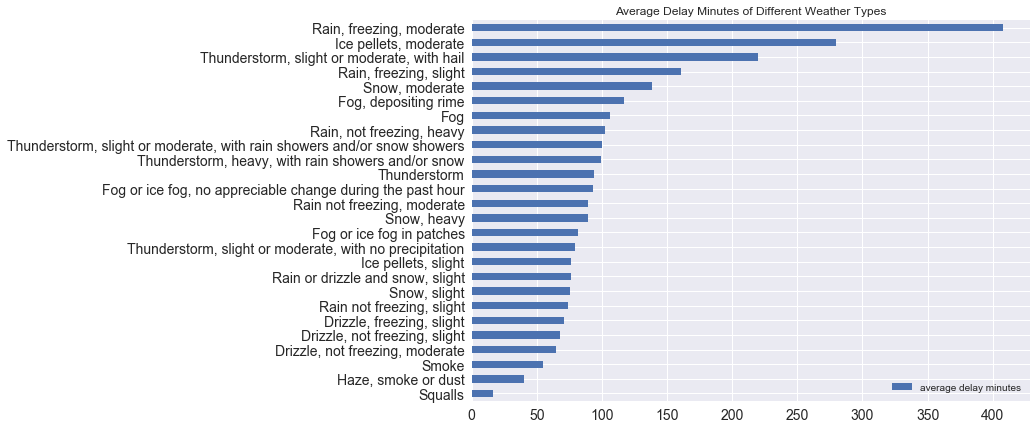

In [33]:
new_avr_df = pd.DataFrame.from_dict(new_avr_dict, orient='index', columns=['average delay minutes']).sort_values(by='average delay minutes')
new_avr_df.plot(kind='barh', title='Average Delay Minutes of Different Weather Types', figsize=(10,7), fontsize=14)

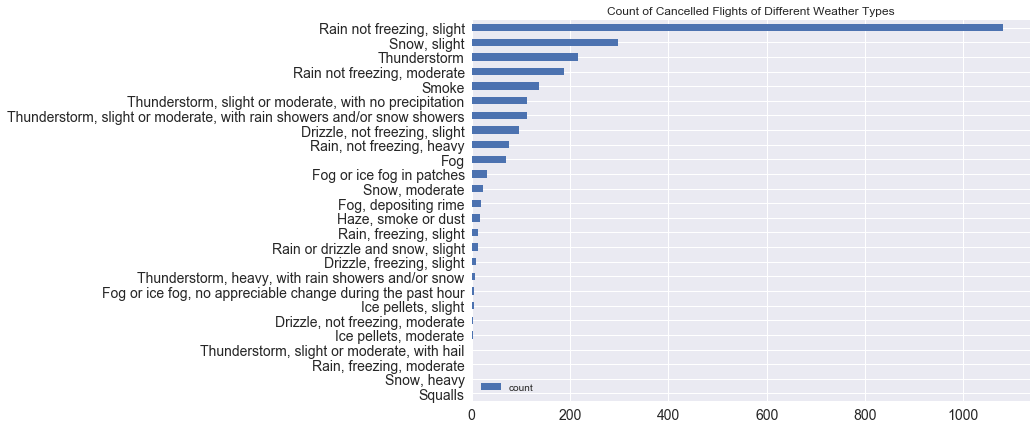

In [34]:
new_res_df = pd.DataFrame.from_dict(new_res_dict, orient='index', columns=['count']).sort_values(by='count')
new_res_df.plot(kind='barh', title='Count of Cancelled Flights of Different Weather Types', figsize=(10,7), fontsize=14)

In [ ]:
# generate delay_and_weather_type.csv
weather_delay_df = pd.concat([new_res_df, new_avr_df], axis=1).sort_values(by='average delay minutes', ascending=False).reset_index()
weather_delay_df = weather_delay_df.rename(columns={'index': 'weather_type'})
weather_delay_df.to_csv('../Weather Data/data/delay_and_weather_type.csv', index=False)

# Delay / carrier and/or aircraft correlation


In [91]:
tail_num_df = pd.read_csv('./tail_num/cleaned_tail_num_with_model_2.csv')

In [92]:
df = df.merge(tail_num_df.iloc[:, :-1], left_on='TAIL_NUM', right_on='tail_num', how='inner')

In [90]:
# For delayed flights
delayed_flight = df[df['DEP_DELAY'] > 15].reset_index(drop=True)
# delayed_flight = df[(df['CARRIER_DELAY'] > 0) & (df['DEP_DELAY'] > 15)].reset_index(drop=True)
df_flight_time = pd.DataFrame()
df_flight_time['date'] = delayed_flight['FL_DATE']
df_flight_time['time'] = delayed_flight['CRS_DEP_TIME']
df_flight_time['tail_num'] = delayed_flight['TAIL_NUM']
df_flight_time['delay'] = delayed_flight['DEP_DELAY']
df_flight_time['carrier'] = delayed_flight['OP_CARRIER']
df_flight_time['time'] = df_flight_time['time'].apply(lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00' if x >= 100 else '00:'+str(x)+':00')
df_flight_time['datetime'] = df_flight_time['date'].map(str) + '/' + df_flight_time['time']
df_flight_time['datetime'] = pd.to_datetime(df_flight_time['datetime'], format='%Y-%m-%d/%H:%M:%S')
df_flight_time = df_flight_time.merge(tail_num_df.iloc[:, :-1], on='tail_num', how='inner')
df_flight_time['age'] = df_flight_time['datetime'].dt.year - df_flight_time['year']

NameError: name 'tail_num_df' is not defined

In [7]:
df['age'] = df['YEAR'] - df['year']

In [133]:
delayed_flight.loc[5, 'DEP_DELAY']

17.0

In [140]:
delayed_flight.head(10).iloc[:, 25:45]

DEST_STATE_ABR  DEST_STATE_FIPS   DEST_STATE_NM  DEST_WAC  CRS_DEP_TIME  \
0             FL               12         Florida        33          2155   
1             NC               37  North Carolina        36          1130   
2             NC               37  North Carolina        36          1100   
3             KY               21        Kentucky        52          1645   
4             GA               13         Georgia        34          1645   
5             MN               27       Minnesota        63          1105   
6             NV               32          Nevada        85          1425   
7             WA               53      Washington        93          1735   
8             MN               27       Minnesota        63           840   
9             NY               36        New York        22          1906   

   DEP_TIME  DEP_DELAY  DEP_DELAY_NEW  DEP_DEL15  DEP_DELAY_GROUP  \
0    2221.0       26.0           26.0        1.0              1.0   
1    1214.0       44.0           44.0        1.0              2.0   
2    1144.0       44.0           44.0        1.0              2.0   
3    1709.0       24.0           24.0        1.0              1.0   
4    1721.0       36.0           36.0        1.0              2.0   
5    1122.0       17.0           17.0        1.0              1.0   
6    1445.0       20.0           20.0        1.0              1.0   
7    1907.0       92.0           92.0        1.0              6.0   
8     857.0       17.0           17.0        1.0              1.0   
9    1932.0       26.0           26.0        1.0              1.0   

  DEP_TIME_BLK  TAXI_OUT  WHEELS_OFF  WHEELS_ON  TAXI_IN  CRS_ARR_TIME  \
0    2100-2159      17.0      2238.0      522.0      3.0           522   
1    1100-1159      43.0      1257.0     2007.0      4.0          1915   
2    1100-1159      45.0      1229.0     1943.0      4.0          1845   
3    1600-1659      17.0      1726.0     2359.0      3.0          2352   
4    1600-1659      32.0      1753.0       26.0      6.0          2353   
5    1100-1159      28.0      1150.0     1640.0      4.0          1627   
6    1400-1459      10.0      1455.0     1537.0      4.0          1550   
7    1700-1759      35.0      1942.0     2055.0      4.0          1923   
8    0800-0859      14.0       911.0      946.0      5.0           955   
9    1900-1959      26.0      1958.0     2232.0      7.0          2211   

   ARR_TIME  ARR_DELAY  ARR_DELAY_NEW  ARR_DEL15  
0     525.0        3.0            3.0        0.0  
1    2011.0       56.0           56.0        1.0  
2    1947.0       62.0           62.0        1.0  
3       2.0       10.0           10.0        0.0  
4      32.0       39.0           39.0        1.0  
5    1644.0       17.0           17.0        1.0  
6    1541.0       -9.0            0.0        0.0  
7    2059.0       96.0           96.0        1.0  
8     951.0       -4.0            0.0        0.0  
9    2239.0       28.0           28.0        1.0

In [138]:
delayed_flight.head(10).iloc[:, 56:61]

CARRIER_DELAY  WEATHER_DELAY  NAS_DELAY  SECURITY_DELAY  \
0            NaN            NaN        NaN             NaN   
1            0.0           21.0       12.0             0.0   
2           12.0            0.0       18.0             0.0   
3            NaN            NaN        NaN             NaN   
4            2.0            0.0        3.0             0.0   
5           17.0            0.0        0.0             0.0   
6            NaN            NaN        NaN             NaN   
7           92.0            0.0        4.0             0.0   
8            NaN            NaN        NaN             NaN   
9            0.0            0.0       28.0             0.0   

   LATE_AIRCRAFT_DELAY  
0                  NaN  
1                 23.0  
2                 32.0  
3                  NaN  
4                 34.0  
5                  0.0  
6                  NaN  
7                  0.0  
8                  NaN  
9                  0.0

In [147]:
delayed_flight.iloc[14164, 25:45]

DEST_STATE_ABR            FL
DEST_STATE_FIPS           12
DEST_STATE_NM        Florida
DEST_WAC                  33
CRS_DEP_TIME            1530
DEP_TIME                1759
DEP_DELAY                149
DEP_DELAY_NEW            149
DEP_DEL15                  1
DEP_DELAY_GROUP            9
DEP_TIME_BLK       1500-1559
TAXI_OUT                  48
WHEELS_OFF              1847
WHEELS_ON               2114
TAXI_IN                    5
CRS_ARR_TIME            1906
ARR_TIME                2119
ARR_DELAY                133
ARR_DELAY_NEW            133
ARR_DEL15                  1
Name: 14164, dtype: object

In [142]:
delayed_flight[delayed_flight['SECURITY_DELAY'] > 0].iloc[:, 56:61]

CARRIER_DELAY  WEATHER_DELAY  NAS_DELAY  SECURITY_DELAY  \
1007               0.0            0.0        0.0            31.0   
1192               0.0            0.0       38.0            37.0   
2996               0.0            0.0        0.0           121.0   
3396               0.0            0.0       21.0            62.0   
4441               0.0            0.0        0.0           182.0   
5131               0.0            0.0        0.0           118.0   
5718               0.0            0.0        0.0            24.0   
6221               0.0            0.0        0.0            33.0   
8498               0.0            0.0        0.0            57.0   
9862               0.0            0.0        9.0            42.0   
10049              0.0            0.0        0.0            39.0   
10587              0.0            0.0        0.0            41.0   
12389              0.0            0.0        0.0           110.0   
13317              0.0            0.0        0.0           137.0   
13840             76.0            0.0        0.0            88.0   
14164              0.0            0.0        0.0            78.0   
18965             54.0            0.0        3.0            54.0   
24379              0.0            0.0        0.0            80.0   
26094              0.0            0.0        0.0            30.0   
26384              0.0            0.0        0.0            44.0   
28592              0.0            0.0        0.0           124.0   
28664              0.0            0.0        0.0            47.0   
28898              0.0            0.0        0.0            29.0   
31922              0.0            0.0        0.0            25.0   
36415              0.0            0.0        0.0            19.0   
37378              0.0            0.0        9.0            50.0   
39179              0.0            0.0       18.0            75.0   
40079              0.0            0.0        0.0            39.0   
41683              0.0            0.0       13.0            48.0   
43719              0.0            0.0        9.0            35.0   
...                ...            ...        ...             ...   
1889545            0.0            0.0        0.0            71.0   
1889915            0.0            0.0        8.0            19.0   
1890153            0.0            0.0        7.0            28.0   
1890207            0.0            0.0        7.0            29.0   
1890338            0.0            0.0        0.0             6.0   
1890365            0.0            0.0        0.0            25.0   
1890463            0.0            0.0        6.0            19.0   
1890475            0.0            0.0        6.0            54.0   
1890537            0.0            0.0        0.0            17.0   
1893054            0.0            0.0        0.0            32.0   
1893110            0.0            0.0        5.0            20.0   
1893229            0.0            0.0        0.0            15.0   
1893242            0.0            0.0        0.0             3.0   
1893259            0.0            0.0        0.0            13.0   
1893596            0.0            0.0        0.0           209.0   
1893782            0.0            0.0        0.0            11.0   
1893817            0.0            0.0        0.0           102.0   
1893832            0.0            0.0        0.0            15.0   
1894074            0.0            0.0       22.0             9.0   
1894148            0.0            0.0        0.0             4.0   
1895440            0.0            0.0        0.0            22.0   
1895929            0.0            0.0        0.0           132.0   
1895988            0.0            0.0        0.0            19.0   
1896247            0.0            0.0        8.0            48.0   
1896330            0.0            0.0        0.0            52.0   
1897353            0.0            0.0       22.0            39.0   
1897541            0.0            0.0        0.0            11.0 

In [111]:
delayed_flight.columns.values

array(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
       'FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID',
       'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID',
       'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN',
       'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS',
       'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID',
       'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST',
       'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_FIPS',
       'DEST_STATE_NM', 'DEST_WAC', 'CRS_DEP_TIME', 'DEP_TIME',
       'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP',
       'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
       'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW',
       'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK', 'CANCELLED',
       'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE',
       'DISTAN

## Delay to plane age

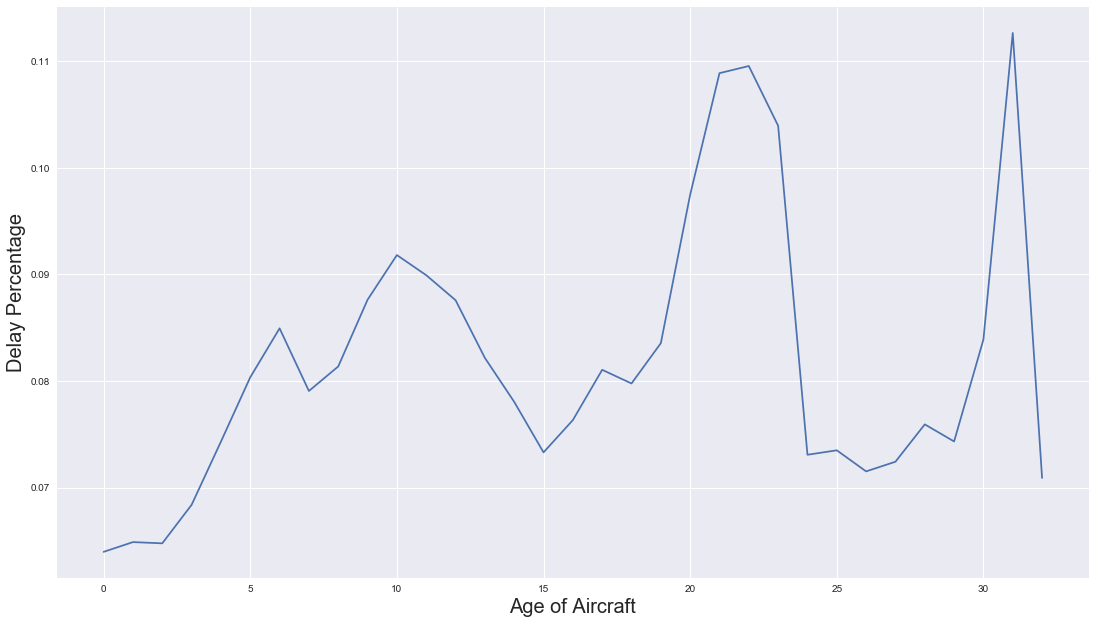

In [174]:
all_flights_age_count = np.array(df.groupby('age').DEP_DELAY.count().tolist()[1:])
delay_flights_age_count = np.array(df_flight_time.groupby('age').delay.count().tolist()[1:])
plt.plot(range(0,33), delay_flights_age_count / all_flights_age_count)
plt.xlabel('Age of Aircraft', fontsize=20)
plt.ylabel('Delay Percentage', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

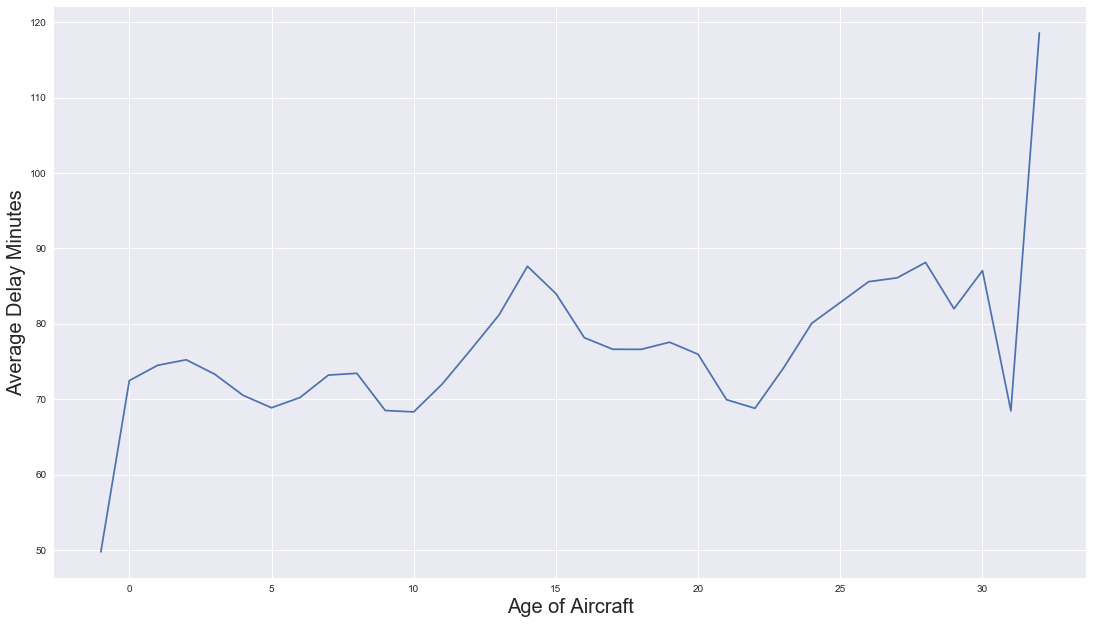

In [184]:
delayed_flight_age = delayed_flight.groupby('age').DEP_DELAY.mean()
plt.plot(delayed_flight_age.index, delayed_flight_age.values)
plt.xlabel('Age of Aircraft', fontsize=20)
plt.ylabel('Average Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

## Delay to carrier

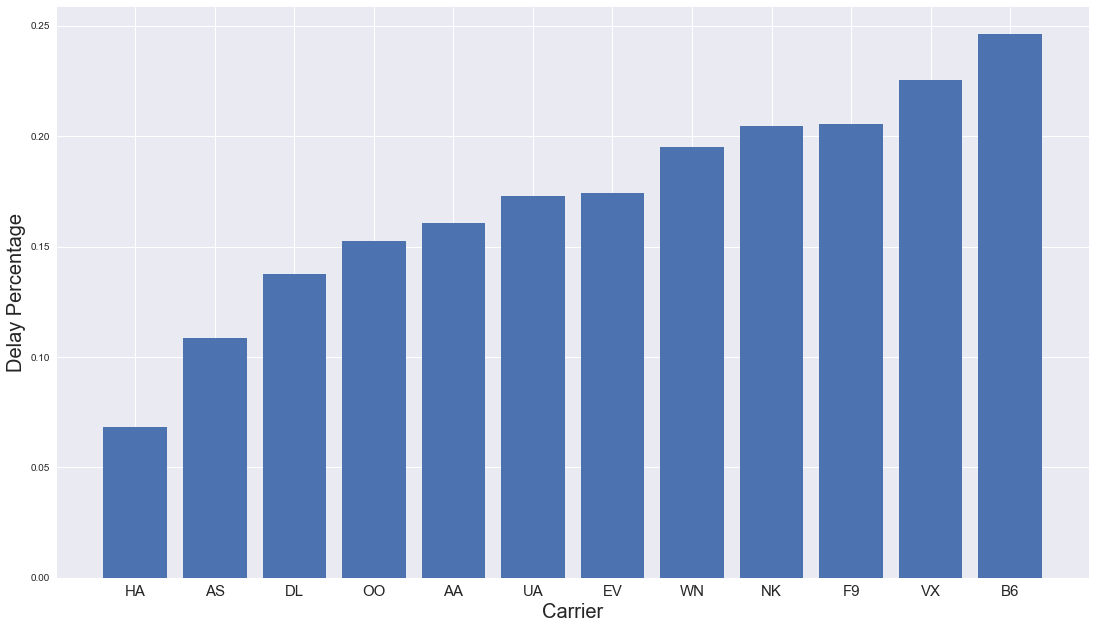

In [109]:
all_flights_carrier_count = np.array(df.groupby('OP_CARRIER').DEP_DELAY.count().tolist())
delay_flights_carrier_count = np.array(df_flight_time.groupby('carrier').delay.count().tolist())
carrier_names = df.groupby('OP_CARRIER').DEP_DELAY.count().index.tolist()
carrier_delay_percentage = pd.DataFrame(delay_flights_carrier_count / all_flights_carrier_count, index=carrier_names, columns=['delay_percentage'])
carrier_delay_percentage = carrier_delay_percentage.sort_values(by='delay_percentage')
plt.bar(carrier_delay_percentage.index, carrier_delay_percentage.delay_percentage)
plt.xticks(delayed_flight_carrier.index, fontsize=15)
plt.xlabel('Carrier', fontsize=20)
plt.ylabel('Delay Percentage', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

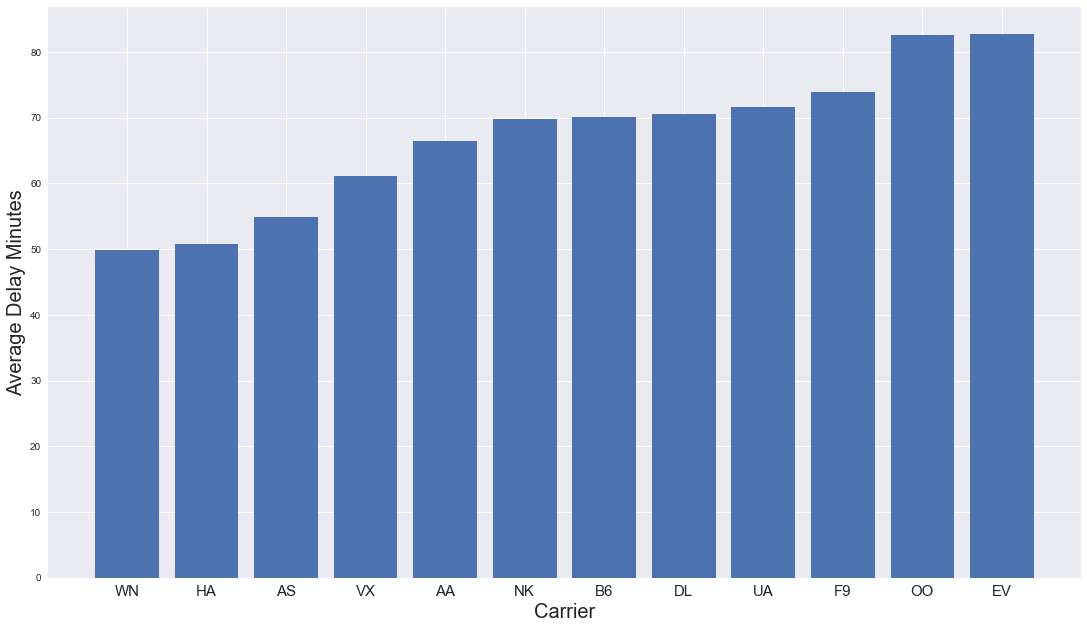

In [108]:
delayed_flight_carrier = delayed_flight.groupby('OP_CARRIER').DEP_DELAY.mean().sort_values()
plt.bar(delayed_flight_carrier.index, delayed_flight_carrier.values)
plt.xticks(delayed_flight_carrier.index, fontsize=15)
plt.xlabel('Carrier', fontsize=20)
plt.ylabel('Average Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

## Delay to plane manufacturer

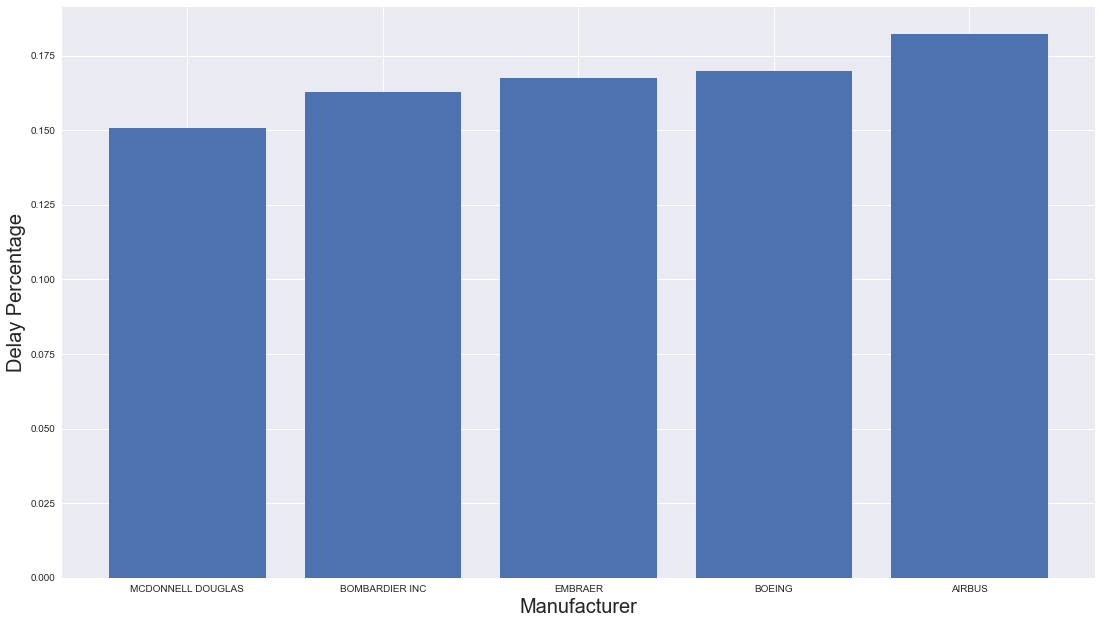

In [104]:
all_flights_mfr_count = np.array(df.groupby('mfr_name').DEP_DELAY.count().tolist())
delay_flights_mfr_count = np.array(df_flight_time.groupby('mfr_name').delay.count().tolist())
mfr_names = df.groupby('mfr_name').DEP_DELAY.count().index.tolist()
mfr_delay_percentage = pd.DataFrame(delay_flights_mfr_count / all_flights_mfr_count, index=mfr_names, columns=['delay_percentage'])
mfr_delay_percentage = mfr_delay_percentage.sort_values(by='delay_percentage')
plt.bar(mfr_delay_percentage.index, mfr_delay_percentage.delay_percentage)
plt.xticks(mfr_delay_percentage.index)
plt.xlabel('Manufacturer', fontsize=20)
plt.ylabel('Delay Percentage', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

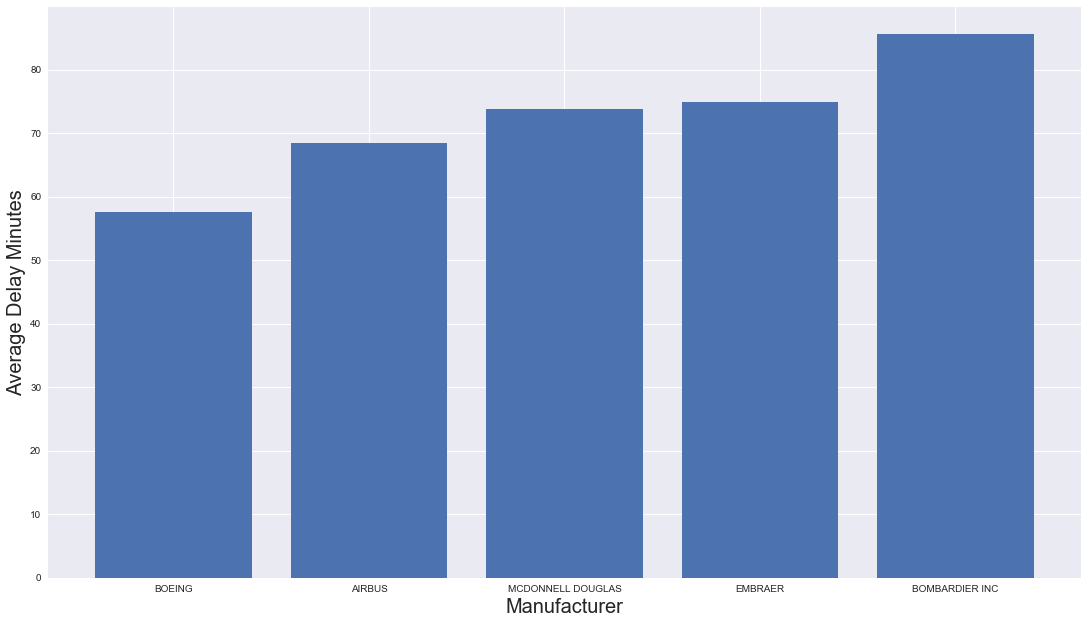

In [105]:
delayed_flight_mfr = delayed_flight.groupby('mfr_name').DEP_DELAY.mean().sort_values()
plt.bar(delayed_flight_mfr.index, delayed_flight_mfr.values)
plt.xticks(delayed_flight_mfr.index)
plt.xlabel('Manufacturer', fontsize=20)
plt.ylabel('Average Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

## Delay to aircraft model

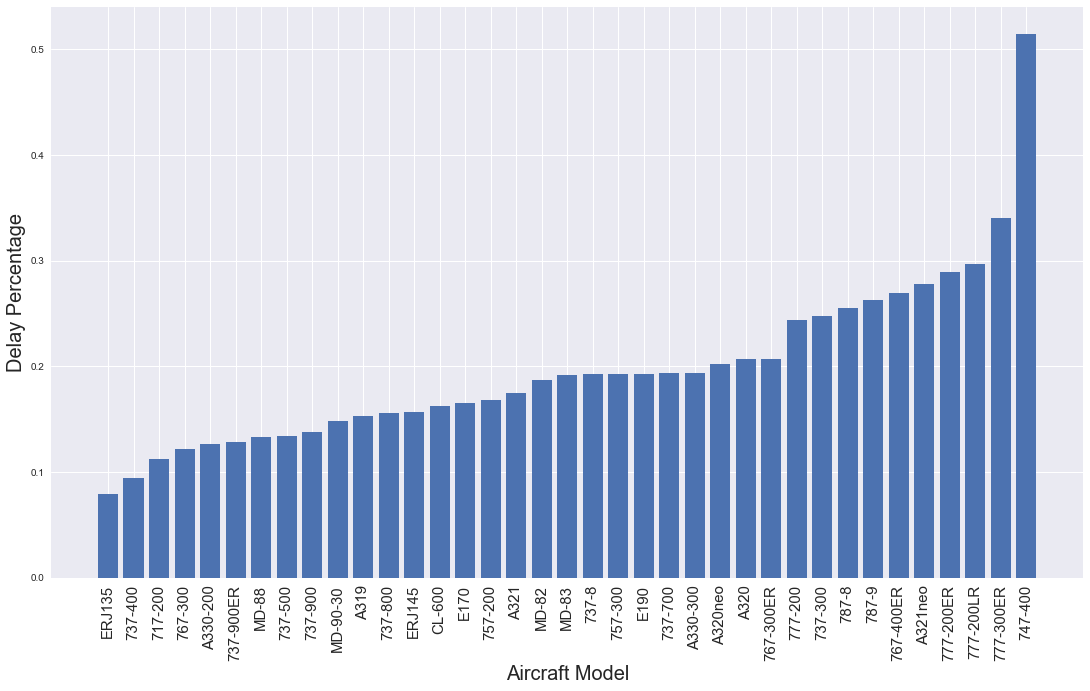

In [82]:
all_flights_model_count = np.array(df.groupby('model_2').DEP_DELAY.count().tolist())
delay_flights_model_count = np.array(df_flight_time.groupby('model_2').delay.count().tolist())
model_names = df.groupby('model_2').DEP_DELAY.count().index.tolist()
model_delay_percentage = pd.DataFrame(delay_flights_model_count / all_flights_model_count, index=model_names, columns=['delay_percentage'])
model_delay_percentage = model_delay_percentage.sort_values(by='delay_percentage')
plt.bar(model_delay_percentage.index, model_delay_percentage.delay_percentage)
plt.xticks(model_delay_percentage.index, rotation=90, fontsize=15)
plt.xlabel('Aircraft Model', fontsize=20)
plt.ylabel('Delay Percentage', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

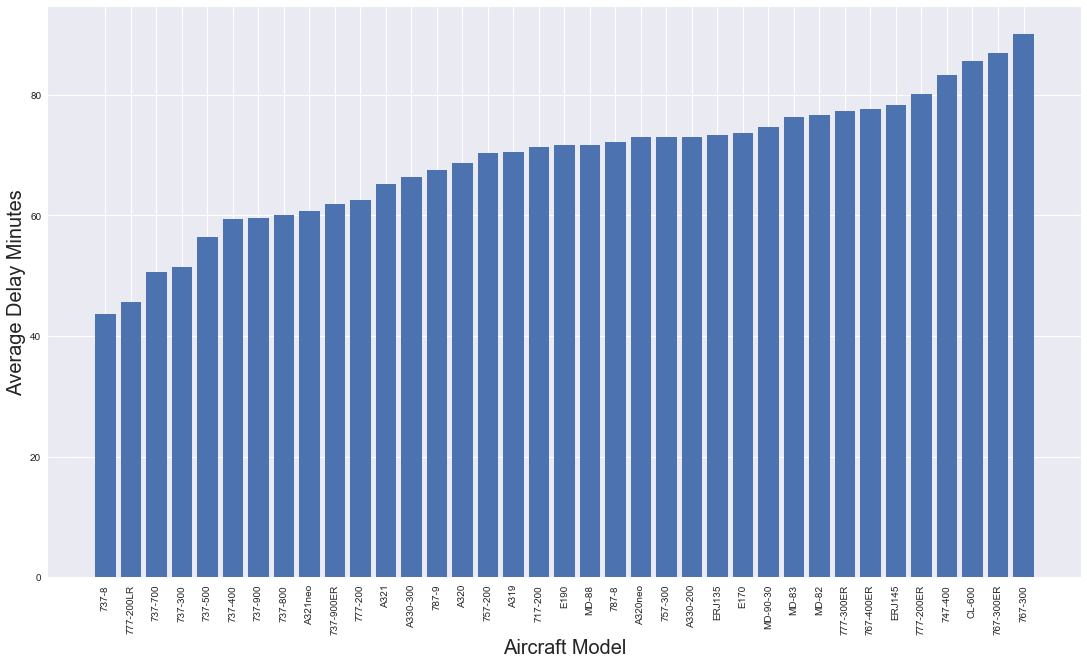

In [86]:
delayed_flight_model = delayed_flight.groupby('model_2').DEP_DELAY.mean().sort_values()
plt.bar(delayed_flight_model.index, delayed_flight_model.values)
plt.xticks(delayed_flight_model.index, rotation=90)
plt.xlabel('Aircraft Model', fontsize=20)
plt.ylabel('Average Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

## Delay to engine manufacturer

Text(0,0.5,'Delay Percentage')

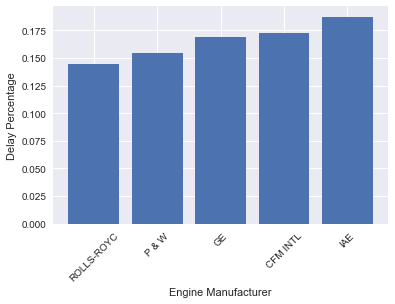

In [87]:
all_flights_eng_mfr_count = np.array(df.groupby('eng_mfr_name').DEP_DELAY.count().tolist())
delay_flights_eng_mfr_count = np.array(df_flight_time.groupby('eng_mfr_name').delay.count().tolist())
eng_mfr_names = df.groupby('eng_mfr_name').DEP_DELAY.count().index.tolist()
eng_mfr_delay_percentage = pd.DataFrame(delay_flights_eng_mfr_count / all_flights_eng_mfr_count, index=eng_mfr_names, columns=['delay_percentage'])
eng_mfr_delay_percentage = eng_mfr_delay_percentage.sort_values(by='delay_percentage')
plt.bar(eng_mfr_delay_percentage.index, eng_mfr_delay_percentage.delay_percentage)
plt.xticks(eng_mfr_delay_percentage.index, rotation=45)
plt.xlabel('Engine Manufacturer')
plt.ylabel('Delay Percentage')

Text(0,0.5,'Average Delay Minutes')

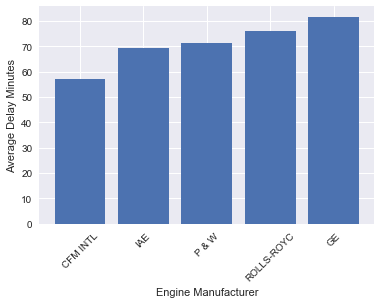

In [88]:
delayed_flight_eng_mfr = delayed_flight.groupby('eng_mfr_name').DEP_DELAY.mean().sort_values()
plt.bar(delayed_flight_eng_mfr.index, delayed_flight_eng_mfr.values)
plt.xticks(delayed_flight_eng_mfr.index, rotation=45)
plt.xlabel('Engine Manufacturer')
plt.ylabel('Average Delay Minutes')

## Delay to engine model

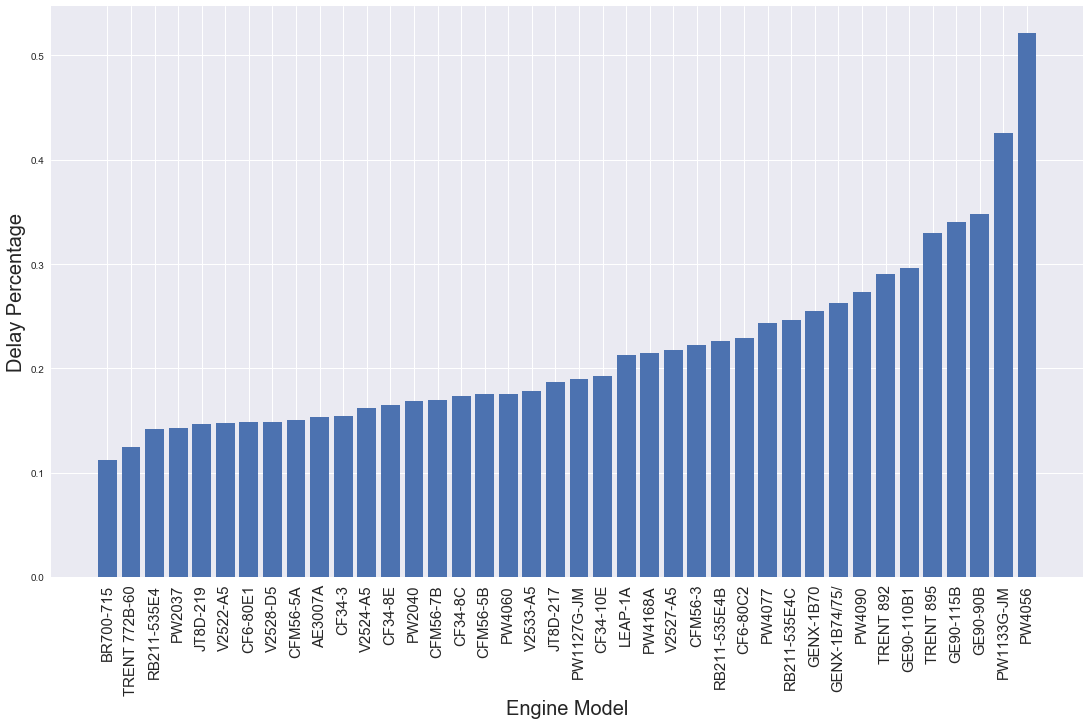

In [90]:
all_flights_eng_model_count = np.array(df.groupby('eng_model').DEP_DELAY.count().tolist())
delay_flights_eng_model_count = np.array(df_flight_time.groupby('eng_model').delay.count().tolist())
eng_model_names = df.groupby('eng_model').DEP_DELAY.count().index.tolist()
eng_model_delay_percentage = pd.DataFrame(delay_flights_eng_model_count / all_flights_eng_model_count, index=eng_model_names, columns=['delay_percentage'])
eng_model_delay_percentage = eng_model_delay_percentage.sort_values(by='delay_percentage')
plt.bar(eng_model_delay_percentage.index, eng_model_delay_percentage.delay_percentage)
plt.xticks(eng_model_delay_percentage.index, rotation=90, fontsize=15)
plt.xlabel('Engine Model', fontsize=20)
plt.ylabel('Delay Percentage', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

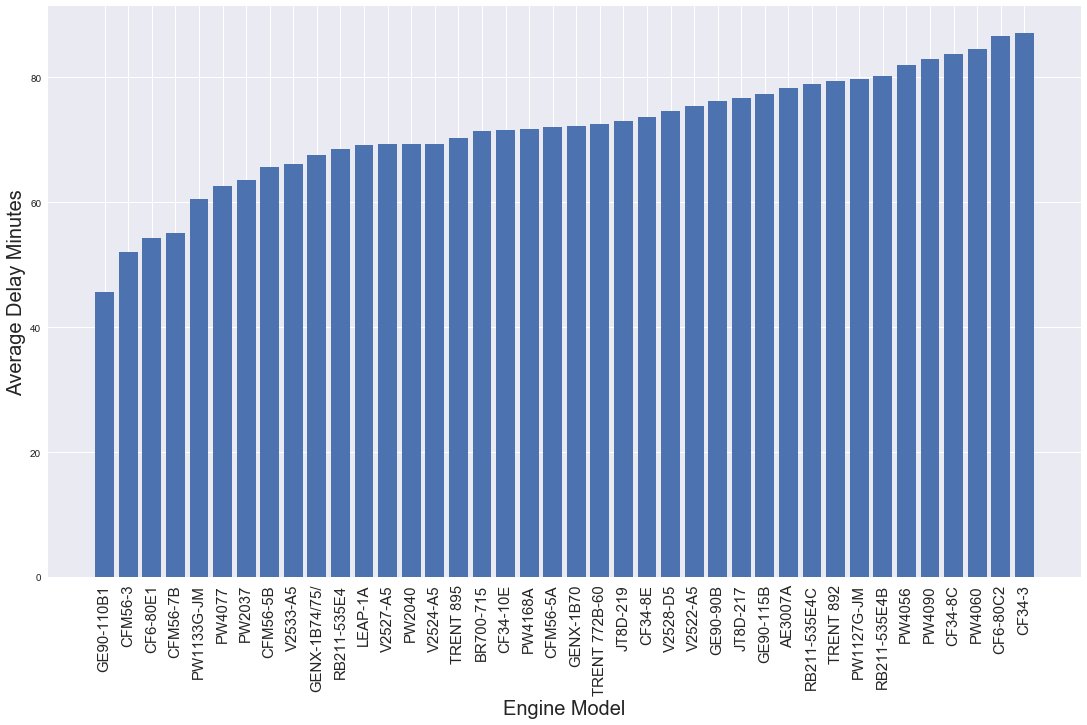

In [92]:
delayed_flight_eng_model = delayed_flight.groupby('eng_model').DEP_DELAY.mean().sort_values()
plt.bar(delayed_flight_eng_model.index, delayed_flight_eng_model.values)
plt.xticks(delayed_flight_eng_model.index, rotation=90, fontsize=15)
plt.xlabel('Engine Model', fontsize=20)
plt.ylabel('Average Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

# Carrier Delay

In [149]:
# For delayed flights
# delayed_flight = df[df['DEP_DELAY'] > 15].reset_index(drop=True)
delayed_flight = df[(df['CARRIER_DELAY'] > 0) & (df['DEP_DELAY'] > 15)].reset_index(drop=True)
df_flight_time = pd.DataFrame()
df_flight_time['date'] = delayed_flight['FL_DATE']
df_flight_time['time'] = delayed_flight['CRS_DEP_TIME']
df_flight_time['tail_num'] = delayed_flight['TAIL_NUM']
df_flight_time['delay'] = delayed_flight['CARRIER_DELAY']
df_flight_time['carrier'] = delayed_flight['OP_CARRIER']
df_flight_time['time'] = df_flight_time['time'].apply(lambda x: str(x)[:-2]+':'+str(x)[-2:]+':00' if x >= 100 else '00:'+str(x)+':00')
df_flight_time['datetime'] = df_flight_time['date'].map(str) + '/' + df_flight_time['time']
df_flight_time['datetime'] = pd.to_datetime(df_flight_time['datetime'], format='%Y-%m-%d/%H:%M:%S')
df_flight_time = df_flight_time.merge(tail_num_df.iloc[:, :-1], on='tail_num', how='inner')
df_flight_time['age'] = df_flight_time['datetime'].dt.year - df_flight_time['year']

## Carrier Delay to Age

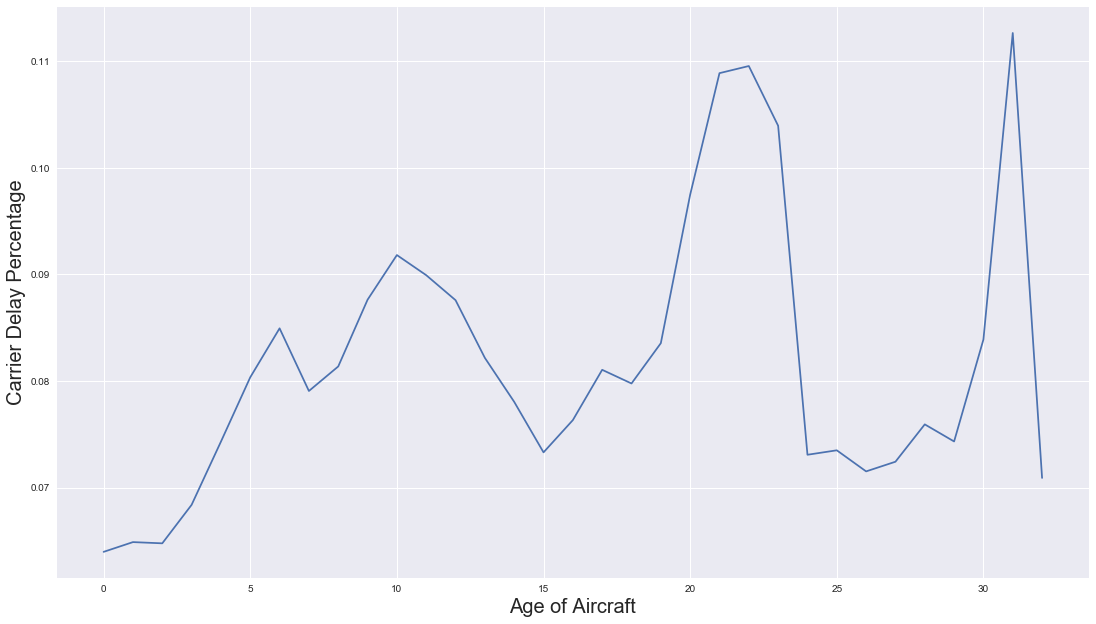

In [185]:
all_flights_age_count = np.array(df.groupby('age').DEP_DELAY.count().tolist()[1:])
delay_flights_age_count = np.array(df_flight_time.groupby('age').delay.count().tolist()[1:])
plt.plot(range(0,33), delay_flights_age_count / all_flights_age_count)
plt.xlabel('Age of Aircraft', fontsize=20)
plt.ylabel('Carrier Delay Percentage', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

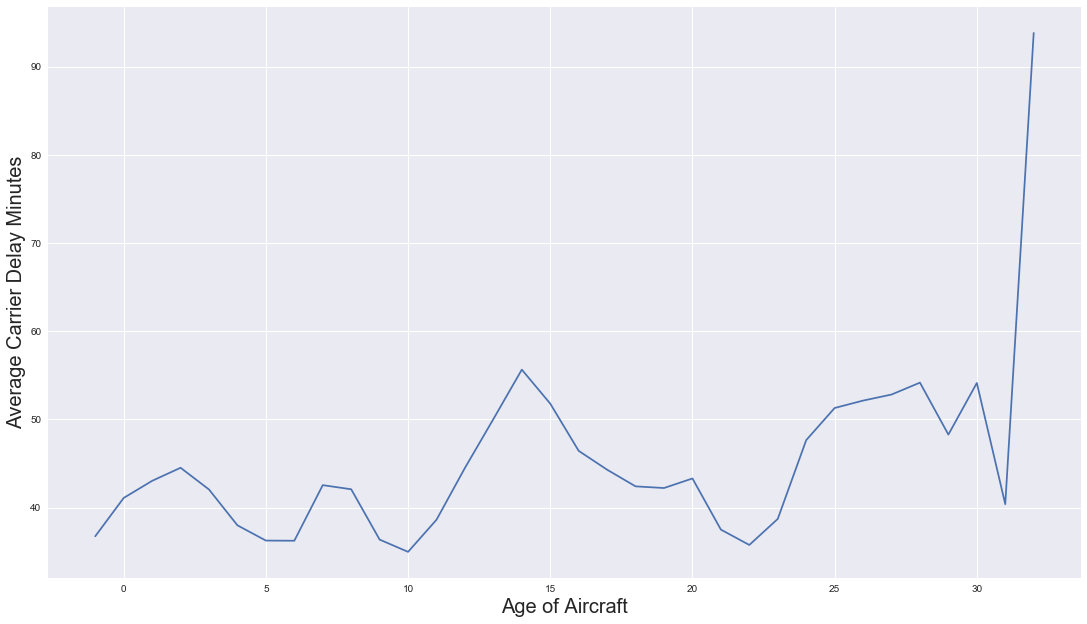

In [186]:
delayed_flight_age = delayed_flight.groupby('age').CARRIER_DELAY.mean()
plt.plot(delayed_flight_age.index, delayed_flight_age.values)
plt.xlabel('Age of Aircraft', fontsize=20)
plt.ylabel('Average Carrier Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

## Carrier Delay to carrier

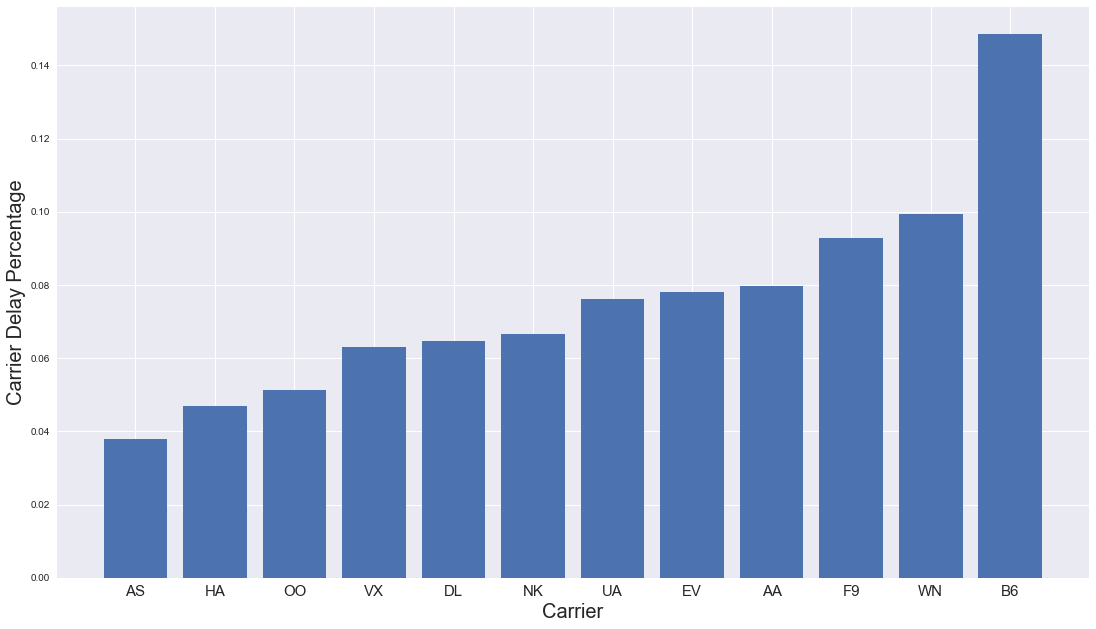

In [157]:
all_flights_carrier_count = np.array(df.groupby('OP_CARRIER').DEP_DELAY.count().tolist())
delay_flights_carrier_count = np.array(df_flight_time.groupby('carrier').delay.count().tolist())
carrier_names = df.groupby('OP_CARRIER').CARRIER_DELAY.count().index.tolist()
carrier_delay_percentage = pd.DataFrame(delay_flights_carrier_count / all_flights_carrier_count, index=carrier_names, columns=['delay_percentage'])
carrier_delay_percentage = carrier_delay_percentage.sort_values(by='delay_percentage')
plt.bar(carrier_delay_percentage.index, carrier_delay_percentage.delay_percentage)
plt.xticks(delayed_flight_carrier.index, fontsize=15)
plt.xlabel('Carrier', fontsize=20)
plt.ylabel('Carrier Delay Percentage', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

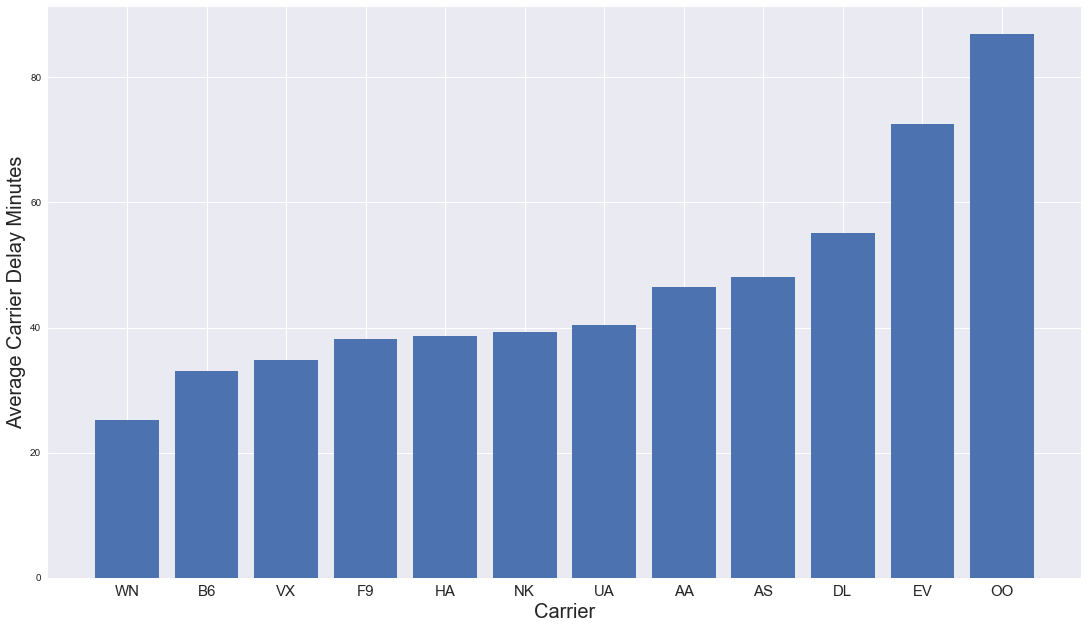

In [158]:
delayed_flight_carrier = delayed_flight.groupby('OP_CARRIER').CARRIER_DELAY.mean().sort_values()
plt.bar(delayed_flight_carrier.index, delayed_flight_carrier.values)
plt.xticks(delayed_flight_carrier.index, fontsize=15)
plt.xlabel('Carrier', fontsize=20)
plt.ylabel('Average Carrier Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

## Carrier Delay to plane manufacturer

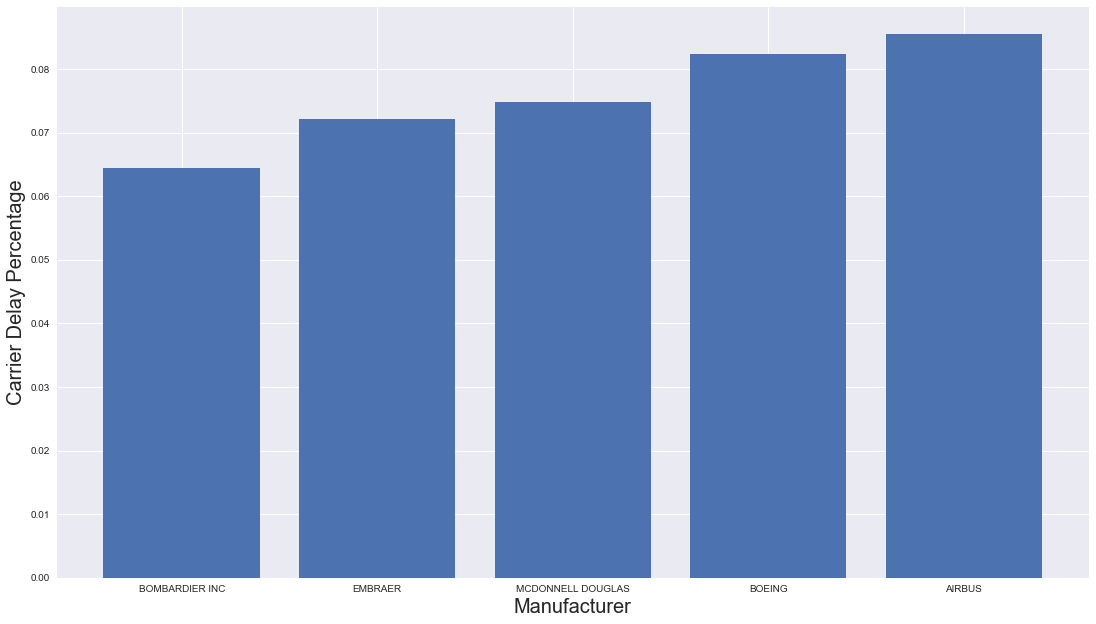

In [163]:
all_flights_mfr_count = np.array(df.groupby('mfr_name').DEP_DELAY.count().tolist())
delay_flights_mfr_count = np.array(df_flight_time.groupby('mfr_name').delay.count().tolist())
mfr_names = df.groupby('mfr_name').DEP_DELAY.count().index.tolist()
mfr_delay_percentage = pd.DataFrame(delay_flights_mfr_count / all_flights_mfr_count, index=mfr_names, columns=['delay_percentage'])
mfr_delay_percentage = mfr_delay_percentage.sort_values(by='delay_percentage')
plt.bar(mfr_delay_percentage.index, mfr_delay_percentage.delay_percentage)
plt.xticks(mfr_delay_percentage.index)
plt.xlabel('Manufacturer', fontsize=20)
plt.ylabel('Carrier Delay Percentage', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

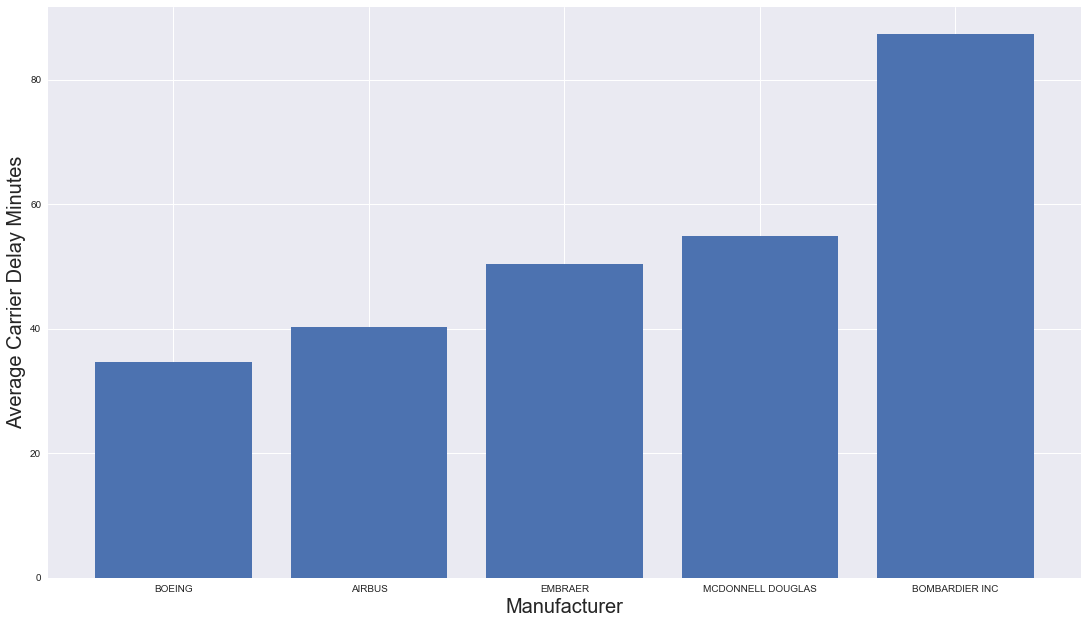

In [162]:
delayed_flight_mfr = delayed_flight.groupby('mfr_name').CARRIER_DELAY.mean().sort_values()
plt.bar(delayed_flight_mfr.index, delayed_flight_mfr.values)
plt.xticks(delayed_flight_mfr.index)
plt.xlabel('Manufacturer', fontsize=20)
plt.ylabel('Average Carrier Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

## Carrier Delay to aircraft model

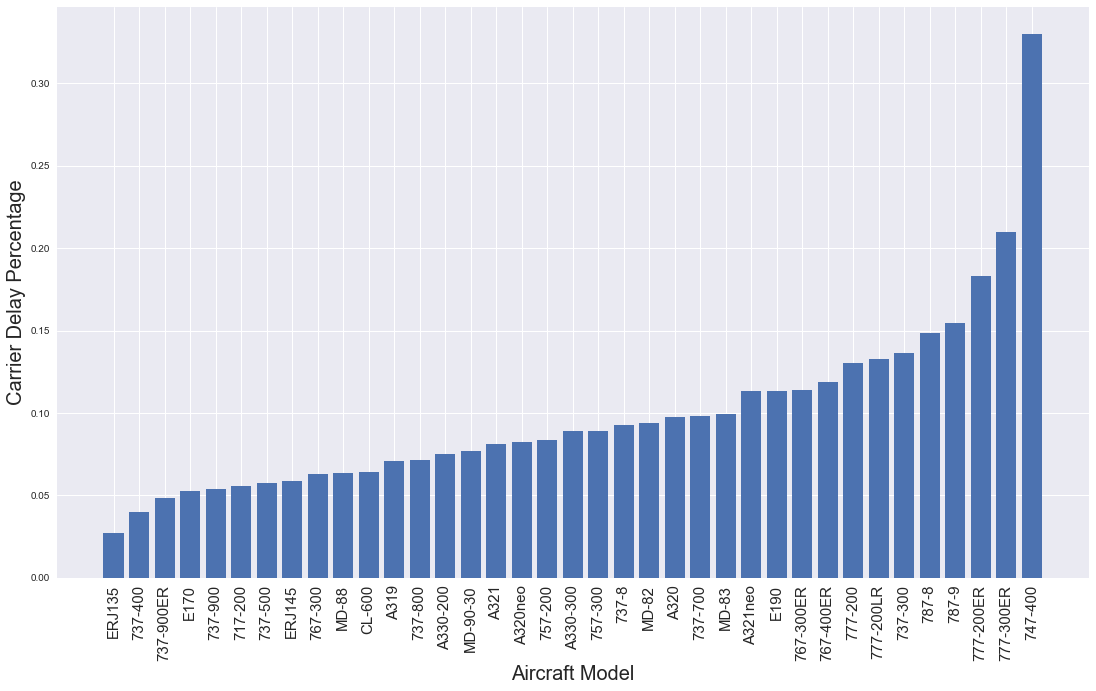

In [164]:
all_flights_model_count = np.array(df.groupby('model_2').DEP_DELAY.count().tolist())
delay_flights_model_count = np.array(df_flight_time.groupby('model_2').delay.count().tolist())
model_names = df.groupby('model_2').DEP_DELAY.count().index.tolist()
model_delay_percentage = pd.DataFrame(delay_flights_model_count / all_flights_model_count, index=model_names, columns=['delay_percentage'])
model_delay_percentage = model_delay_percentage.sort_values(by='delay_percentage')
plt.bar(model_delay_percentage.index, model_delay_percentage.delay_percentage)
plt.xticks(model_delay_percentage.index, rotation=90, fontsize=15)
plt.xlabel('Aircraft Model', fontsize=20)
plt.ylabel('Carrier Delay Percentage', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

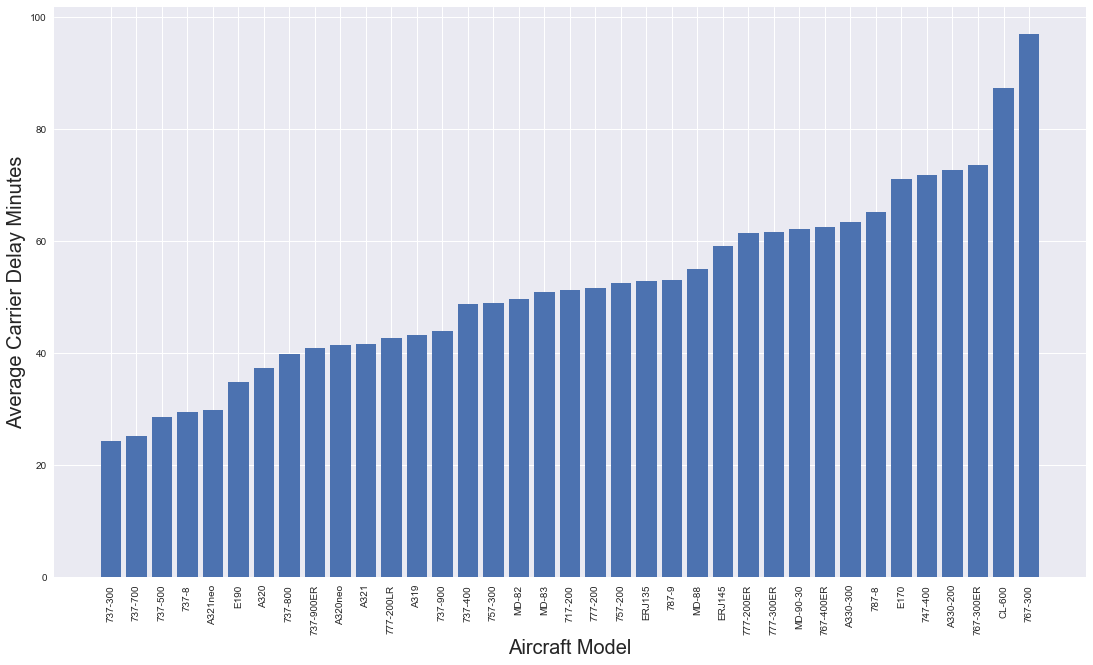

In [165]:
delayed_flight_model = delayed_flight.groupby('model_2').CARRIER_DELAY.mean().sort_values()
plt.bar(delayed_flight_model.index, delayed_flight_model.values)
plt.xticks(delayed_flight_model.index, rotation=90)
plt.xlabel('Aircraft Model', fontsize=20)
plt.ylabel('Average Carrier Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

## Carrier Delay to engine manufacturer

Text(0,0.5,'Carrier Delay Percentage')

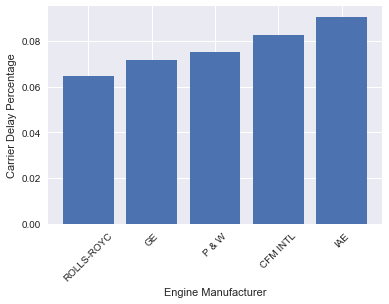

In [166]:
all_flights_eng_mfr_count = np.array(df.groupby('eng_mfr_name').DEP_DELAY.count().tolist())
delay_flights_eng_mfr_count = np.array(df_flight_time.groupby('eng_mfr_name').delay.count().tolist())
eng_mfr_names = df.groupby('eng_mfr_name').DEP_DELAY.count().index.tolist()
eng_mfr_delay_percentage = pd.DataFrame(delay_flights_eng_mfr_count / all_flights_eng_mfr_count, index=eng_mfr_names, columns=['delay_percentage'])
eng_mfr_delay_percentage = eng_mfr_delay_percentage.sort_values(by='delay_percentage')
plt.bar(eng_mfr_delay_percentage.index, eng_mfr_delay_percentage.delay_percentage)
plt.xticks(eng_mfr_delay_percentage.index, rotation=45)
plt.xlabel('Engine Manufacturer')
plt.ylabel('Carrier Delay Percentage')

Text(0,0.5,'Average Carrier Delay Minutes')

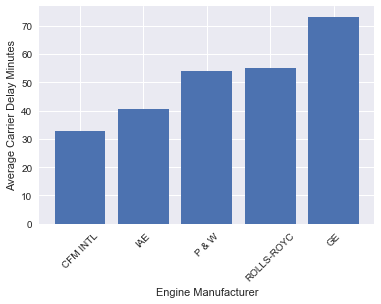

In [167]:
delayed_flight_eng_mfr = delayed_flight.groupby('eng_mfr_name').CARRIER_DELAY.mean().sort_values()
plt.bar(delayed_flight_eng_mfr.index, delayed_flight_eng_mfr.values)
plt.xticks(delayed_flight_eng_mfr.index, rotation=45)
plt.xlabel('Engine Manufacturer')
plt.ylabel('Average Carrier Delay Minutes')

## Carrier Delay to engine model

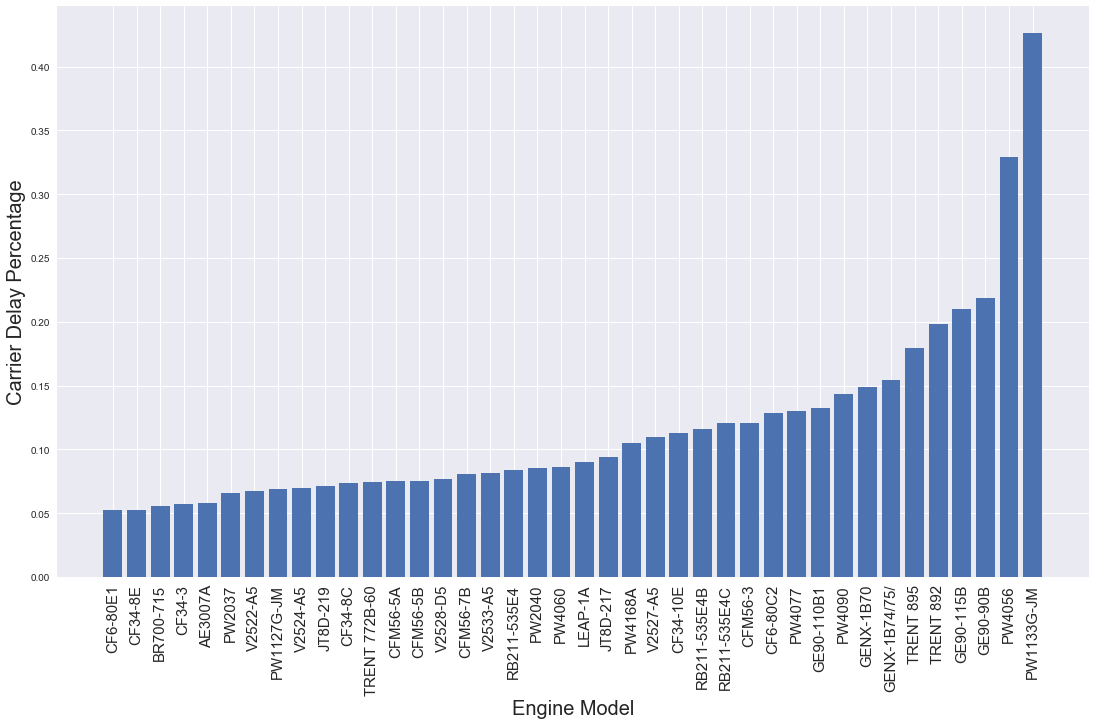

In [168]:
all_flights_eng_model_count = np.array(df.groupby('eng_model').DEP_DELAY.count().tolist())
delay_flights_eng_model_count = np.array(df_flight_time.groupby('eng_model').delay.count().tolist())
eng_model_names = df.groupby('eng_model').DEP_DELAY.count().index.tolist()
eng_model_delay_percentage = pd.DataFrame(delay_flights_eng_model_count / all_flights_eng_model_count, index=eng_model_names, columns=['delay_percentage'])
eng_model_delay_percentage = eng_model_delay_percentage.sort_values(by='delay_percentage')
plt.bar(eng_model_delay_percentage.index, eng_model_delay_percentage.delay_percentage)
plt.xticks(eng_model_delay_percentage.index, rotation=90, fontsize=15)
plt.xlabel('Engine Model', fontsize=20)
plt.ylabel('Carrier Delay Percentage', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

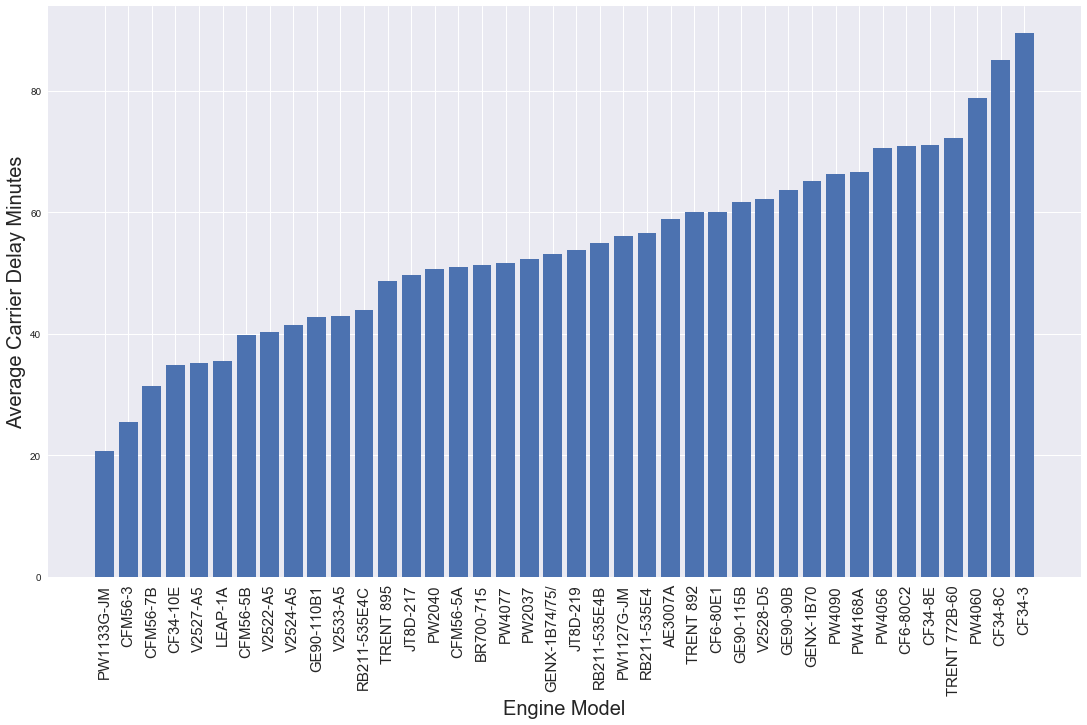

In [169]:
delayed_flight_eng_model = delayed_flight.groupby('eng_model').CARRIER_DELAY.mean().sort_values()
plt.bar(delayed_flight_eng_model.index, delayed_flight_eng_model.values)
plt.xticks(delayed_flight_eng_model.index, rotation=90, fontsize=15)
plt.xlabel('Engine Model', fontsize=20)
plt.ylabel('Average Carrier Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

# Delayed flights on US map

# Calculate delay percentage for airports

In [2]:
from mpl_toolkits.basemap import Basemap as Basemap

In [134]:
stations_df = pd.read_csv('./airport_location.csv')

In [3]:
delay_percentage = pd.read_csv('airport_delay.csv')
delay_percentage['delay_percentage'] = delay_percentage['delay_count'] / delay_percentage['total_count']

In [5]:
delay_percentage['delay_expect'] = delay_percentage['delay_percentage'] * delay_percentage['avr_delay']

In [8]:
delay_percentage.sort_values(by='avr_delay', ascending=False)

origin  all_avr_delay   avr_delay  total_count  delay_count   WBAN  \
320    PPG      31.171548  339.888889          239         27.0  61705   
307    GCK      16.800333  170.354430          601         79.0  23064   
323    ENV     157.000000  157.000000            1          1.0  24193   
69     BTM       5.358377  147.103093         1331         97.0  24135   
305    CIU      16.433807  145.610465         1337        172.0   4869   
287    MQT      13.456885  143.193069         1554        202.0  94836   
31     HLN       2.068522  134.900585         3342        171.0  24144   
14     LWS      -1.487705  134.061538         1464         65.0  24149   
85     INL       6.061538  132.950000         1235        120.0  14918   
271    CMX      12.294760  130.105556         1374        180.0  14858   
78     RHI       5.715831  129.994413         1756        179.0   4803   
152    MOT       8.141083  128.733945         3140        327.0  24013   
55     LCH       4.262876  127.240000         2427        225.0   3937   
268    MHK      12.122517  124.717557          906        131.0   3936   
229    IMT      10.419355  124.465839         1333        161.0  94893   
311    MEI      19.140168  123.582547         2019        424.0  13865   
58     COU       4.640065  122.312500          614         48.0   3945   
37     EKO       2.539422  122.011765         1281         85.0  24121   
233    DLH      10.590298  120.688207         4906        619.0  14913   
72     HIB       5.467732  119.325714         1627        175.0  94931   
301    APN      15.429383  119.177419         1232        186.0  94849   
60     ISN       4.840730  118.834586         2794        266.0  94014   
136    ABR       7.628611  118.623077         1454        130.0  14929   
103    EAU       6.773002  118.094488         1326        127.0  14991   
240    PLN      10.805720  117.756098         2028        287.0  14841   
39     GTF       2.909384  117.212766         3410        235.0  24143   
33     RKS       2.151655  116.273810         1299         84.0  24027   
36     GCC       2.366469  115.807229         2022        166.0  94023   
83     BRD       5.950158  115.292453         1264        106.0  94938   
257    AVP      11.563804  115.002288         3354        437.0  14777   
..     ...            ...         ...          ...          ...    ...   
186    DEN       8.984233   59.725892       444910      77984.0   3017   
140    ABQ       7.878697   59.691115        37765       5999.0  23050   
289    HYA      13.579439   59.574074          214         54.0  94720   
82     PDX       5.949192   59.480733       120492      16816.0  24229   
269    LAX      12.156352   58.847778       423403      94651.0  23174   
134    SAN       7.616014   58.770595       160485      25662.0  23188   
227    LAS      10.368521   57.991228       299839      59277.0  23169   
148    BUR       8.075867   56.913168        46819       8027.0  23152   
190    STL       9.021185   56.734600       111401      19951.0  13994   
91     SEA       6.309540   56.733105       268521      39124.0  24233   
108    SNA       6.921132   56.355695        83557      13028.0  93184   
197    BWI       9.116705   56.288594       193917      34571.0  93721   
159    SMF       8.295806   55.827560        85654      14579.0  93225   
115    PHX       7.087791   54.469830       311890      49005.0  23183   
10     OTZ      -2.533381   53.559701         1393        134.0  26616   
128    SJC       7.438700   52.584858        90424      15361.0  23293   
2      BET      -6.643235   51.672727         1892        110.0  26615   
226    HOU      10.341132   50.404286       106217      21418.0  12918   
221    MDW      10.043900   50.366945       172234      34343.0  14819   
245    DAL      10.978434   49.234554       136926      29571.0  13960   
15     GST      -1.300613   48.000000          163         25.0  25322   
9      OME      -2.710809   47.617021         1397        141.0  26617   
5      D

# Delay by origin airport

In [207]:
# For delayed flights
delayed_flight = df[df['DEP_DELAY'] > 15].reset_index(drop=True)
# delayed_flight = df[(df['CARRIER_DELAY'] > 0) & (df['DEP_DELAY'] > 15)].reset_index(drop=True)
df_flight_time = pd.DataFrame()
df_flight_time['delay'] = delayed_flight['DEP_DELAY']
df_flight_time['origin'] = delayed_flight['ORIGIN']

In [7]:
len(df['ORIGIN'].unique().tolist())

324

In [208]:
delay_flights_origin_count = pd.DataFrame(df_flight_time.groupby('origin').delay.count()).reset_index().rename(columns={'delay': 'delay_count'})
all_flights_origin_count = pd.DataFrame(df.groupby('ORIGIN').DEP_DELAY.count()).reset_index().rename(columns={'DEP_DELAY': 'total_count', 'ORIGIN': 'origin'})

In [209]:
delay_percentage = all_flights_origin_count.merge(delay_flights_origin_count, on='origin', how='left')
delay_percentage = delay_percentage.fillna(0)
delay_percentage = delay_percentage.merge(stations_df, left_on='origin', right_on='IATA', how='left').drop(columns=['IATA'])
delay_percentage['delay_percentage'] = delay_percentage['delay_count'] / delay_percentage['total_count']

In [5]:
delay_percentage = delay_percentage[delay_percentage['total_count'] >= 10]

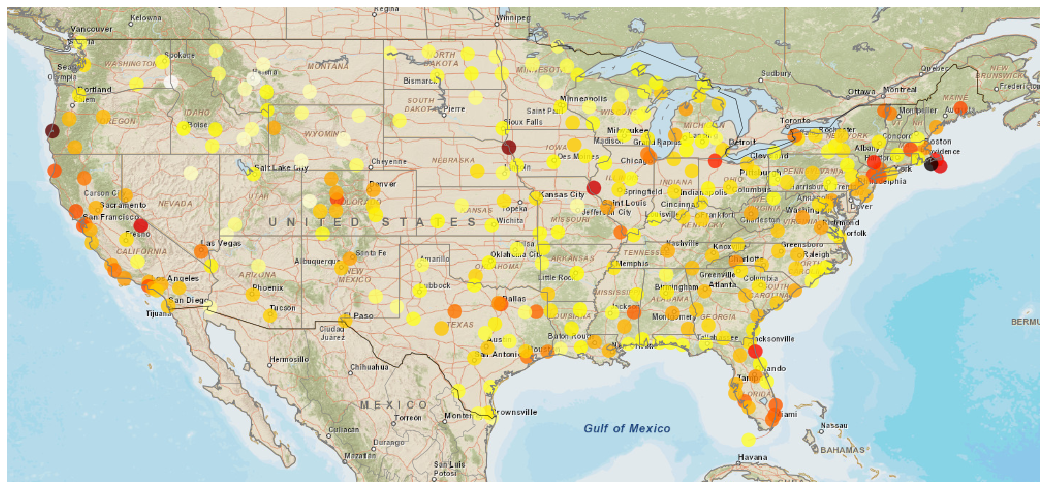

In [99]:
# continental US
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = delay_percentage['LATITUDE'].values
lon = delay_percentage['LONGITUDE'].values
size = delay_percentage['delay_percentage'].values
colors = 1 - size
m = Basemap(llcrnrlon=-127,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=51,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95, resolution='l', epsg=4687)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=1000)
m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot, alpha=0.8, s=200)
# ax_1 = plt.gca()

# plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
fig = plt.gcf()
fig.set_size_inches(18.5, 12)
# newax = fig.add_axes([0.1, 0.2, 0.2, 0.2], anchor='SW', zorder=10)
# newax.imshow(im)
# newax.axis('off')
plt.show()

In [9]:
from math import log10

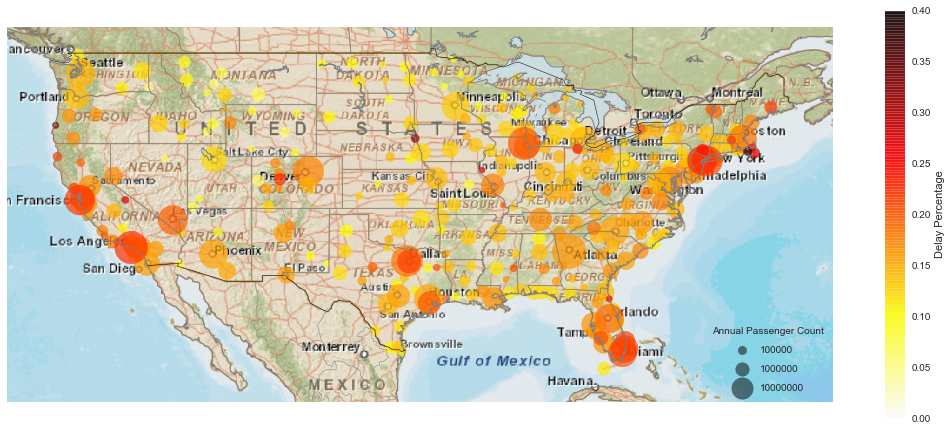

In [14]:
# continental US
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = delay_percentage['LATITUDE'].values
lon = delay_percentage['LONGITUDE'].values
size = delay_percentage['passenger_count'].apply(lambda x: log10(x)).values
colors = delay_percentage['delay_percentage'].values
m = Basemap(llcrnrlon=-128,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=51,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-96, resolution='l', epsg=4687)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=950)
m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.7, s=2.5 ** size)

plt.colorbar(label=r'Delay Percentage')
plt.clim(0, 0.4)

for a in [50000, 500000, 5000000]:
    plt.scatter([], [], c='k', alpha=0.5, s=2.5 ** log10(a),
                label=str(2*a))
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower right', title='Annual Passenger Count')


fig = plt.gcf()
fig.set_size_inches(18.5, 7.5)

plt.show()

In [6]:
from PIL import Image

In [55]:
def fig2data(fig):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw()

    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w, h, 4)
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll (buf, 3, axis=2)
    return buf

In [56]:
def fig2img(fig):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
    buf = fig2data(fig)
    w, h, d = buf.shape
    return Image.frombytes("RGBA", (w ,h), buf.tostring())

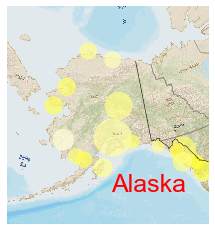

In [16]:
# Alaska
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
# a = plt.axes([.7, .1, .2, .2])
lat = delay_percentage['LATITUDE'].values
lon = delay_percentage['LONGITUDE'].values
size = delay_percentage['passenger_count'].apply(lambda x: log10(x)).values
colors = delay_percentage['delay_percentage'].values
# plt.figure(edgecolor='r', linewidth=2)
m = Basemap(llcrnrlon=-170,llcrnrlat=50,urcrnrlon=-110,urcrnrlat=72,
        projection='lcc',lat_1=59,lat_2=66,lon_0=-142, resolution='l', epsg=2964)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=950)
# m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.7, s=2.5 ** size * 4)
ax_2 = plt.gca()
ax_2.text(.7,.15,'Alaska',
        horizontalalignment='center',
        transform=ax_2.transAxes, color='red', fontsize=25)
# plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
fig_2 = plt.gcf()


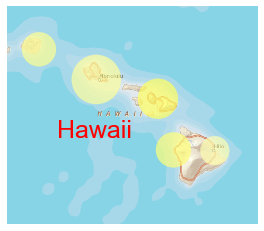

In [17]:
# Hawaii
# df_hawaii = delay_percentage[delay_percentage['STATE'] == 'Hawaii']
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = delay_percentage['LATITUDE'].values
lon = delay_percentage['LONGITUDE'].values
size = delay_percentage['passenger_count'].apply(lambda x: log10(x)).values
colors = delay_percentage['delay_percentage'].values
m = Basemap(llcrnrlon=-160,llcrnrlat=18,urcrnrlon=-154,urcrnrlat=23,
        projection='lcc',lat_1=19.5,lat_2=22,lon_0=-156, resolution='l', epsg=2782)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=500)
# m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.7, s=2.5 ** size * 4)
ax_3 = plt.gca()
ax_3.text(.35,.4,'Hawaii',
        horizontalalignment='center',
        transform=ax_3.transAxes, color='red', fontsize=25)
fig_3 = plt.gcf()

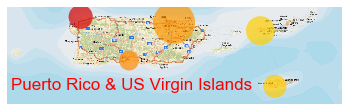

In [18]:
# Puerto Rico & US Virgin Islands
# df_pr = delay_percentage[(delay_percentage['STATE'] == 'Puerto Rico') | (delay_percentage['STATE'] == 'United States Virgin Islands')]
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = delay_percentage['LATITUDE'].values
lon = delay_percentage['LONGITUDE'].values
size = delay_percentage['passenger_count'].apply(lambda x: log10(x)).values
colors = delay_percentage['delay_percentage'].values
m = Basemap(llcrnrlon=-68,llcrnrlat=17.5,urcrnrlon=-64,urcrnrlat=18.6,
        projection='lcc',lat_1=18,lat_2=18.5,lon_0=-66, resolution='l', epsg=2866)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=1000)
# m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.7, s=2.5 ** size * 4)
ax_4 = plt.gca()
ax_4.text(.37,.15,'Puerto Rico & US Virgin Islands',
        horizontalalignment='center',
        transform=ax_4.transAxes, color='red', fontsize=17)
fig_4 = plt.gcf()

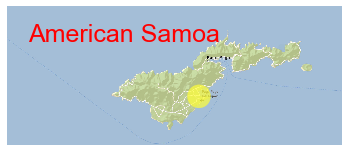

In [19]:
# American Samoa
# df_as = delay_percentage[delay_percentage['STATE'] == 'American Samoa']
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = delay_percentage['LATITUDE'].values
lon = delay_percentage['LONGITUDE'].values
size = delay_percentage['passenger_count'].apply(lambda x: log10(x)).values
colors = delay_percentage['delay_percentage'].values
m = Basemap(llcrnrlon=-171,llcrnrlat=-14.4,urcrnrlon=-170.5,urcrnrlat=-14.2,
        projection='lcc',lat_1=-14.4,lat_2=-14.2,lon_0=-170.75, resolution='l', epsg=3102)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=1000)
# m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.7, s=2.5 ** size * 100 / 16)
ax_5 = plt.gca()
ax_5.text(.35,.75,'American Samoa',
        horizontalalignment='center',
        transform=ax_5.transAxes, color='red', fontsize=25)
fig_5 = plt.gcf()

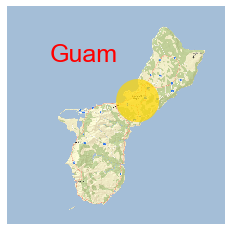

In [20]:
# Guam
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = delay_percentage['LATITUDE'].values
lon = delay_percentage['LONGITUDE'].values
size = delay_percentage['passenger_count'].apply(lambda x: log10(x)).values
colors = delay_percentage['delay_percentage'].values
m = Basemap(llcrnrlon=144.5,llcrnrlat=13.2,urcrnrlon=145,urcrnrlat=13.7,
        projection='lcc',lat_1=13.3,lat_2=13.6,lon_0=144.75, resolution='l', epsg=4675)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=1000)
# m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.7, s=2.5 ** size * 100 / 16)
ax_6 = plt.gca()
ax_6.text(.35,.75,'Guam',
        horizontalalignment='center',
        transform=ax_6.transAxes, color='red', fontsize=25)
fig_6 = plt.gcf()

# Airport Average Delay Minutes

In [290]:
passenger = pd.read_csv('airport_passenger.csv')
passenger.iloc[:, 1] = passenger.iloc[:, 1].str.replace(',','').apply(lambda x: int(x))

In [291]:
passenger = passenger.rename(columns={'17_Enplanements': 'passenger_count'})

In [295]:
avr_delay = avr_delay.merge(passenger, left_on='origin', right_on='IATA', how='left').drop(columns=['IATA'])

In [285]:
all_flights_origin_count = pd.DataFrame(df.groupby('ORIGIN').DEP_DELAY.count()).reset_index().rename(columns={'DEP_DELAY': 'total_count', 'ORIGIN': 'origin'})
delay_flights_origin_count = pd.DataFrame(df_flight_time.groupby('origin').delay.count()).reset_index().rename(columns={'delay': 'delay_count'})

all_flights_average_delay = pd.DataFrame(df.groupby('ORIGIN').DEP_DELAY.mean().sort_values()).reset_index().rename(columns={'DEP_DELAY': 'all_avr_delay', 'ORIGIN': 'origin'})
delay_flights_average_delay = pd.DataFrame(df_flight_time.groupby('origin').delay.mean()).reset_index().rename(columns={'delay': 'avr_delay'})

delay_percentage = all_flights_origin_count.merge(delay_flights_origin_count, on='origin', how='left')
delay_percentage = delay_percentage.fillna(0)

avr_delay = all_flights_average_delay.merge(delay_flights_average_delay, on='origin', how='left')
avr_delay = avr_delay.fillna(0)

avr_delay = avr_delay.merge(delay_percentage, on='origin', how='left')
avr_delay = avr_delay.merge(stations_df, left_on='origin', right_on='IATA', how='left').drop(columns=['IATA'])

In [320]:
avr_delay = avr_delay[avr_delay['total_count'] >= 10]

In [321]:
# set the stations 3 std of avr_day far away mean to mean + 3 std
inx = avr_delay[np.abs(avr_delay.avr_delay - avr_delay.avr_delay.mean()) > (3 * avr_delay.avr_delay.std())].index.tolist()
set_value = avr_delay.avr_delay.mean() + 3 * avr_delay.avr_delay.std()
for i in inx:
    avr_delay.loc[i, 'avr_delay'] = set_value

C:\Users\Qingyu\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [323]:
avr_delay.sort_values(by='avr_delay', ascending=False)

origin  all_avr_delay   avr_delay  total_count  delay_count   WBAN  \
320    PPG      31.171548  162.547586          239         27.0  61705   
307    GCK      16.800333  162.547586          601         79.0  23064   
69     BTM       5.358377  147.103093         1331         97.0  24135   
305    CIU      16.433807  145.610465         1337        172.0   4869   
287    MQT      13.456885  143.193069         1554        202.0  94836   
31     HLN       2.068522  134.900585         3342        171.0  24144   
14     LWS      -1.487705  134.061538         1464         65.0  24149   
85     INL       6.061538  132.950000         1235        120.0  14918   
271    CMX      12.294760  130.105556         1374        180.0  14858   
78     RHI       5.715831  129.994413         1756        179.0   4803   
152    MOT       8.141083  128.733945         3140        327.0  24013   
55     LCH       4.262876  127.240000         2427        225.0   3937   
268    MHK      12.122517  124.717557          906        131.0   3936   
229    IMT      10.419355  124.465839         1333        161.0  94893   
311    MEI      19.140168  123.582547         2019        424.0  13865   
58     COU       4.640065  122.312500          614         48.0   3945   
37     EKO       2.539422  122.011765         1281         85.0  24121   
233    DLH      10.590298  120.688207         4906        619.0  14913   
72     HIB       5.467732  119.325714         1627        175.0  94931   
301    APN      15.429383  119.177419         1232        186.0  94849   
60     ISN       4.840730  118.834586         2794        266.0  94014   
136    ABR       7.628611  118.623077         1454        130.0  14929   
103    EAU       6.773002  118.094488         1326        127.0  14991   
240    PLN      10.805720  117.756098         2028        287.0  14841   
39     GTF       2.909384  117.212766         3410        235.0  24143   
33     RKS       2.151655  116.273810         1299         84.0  24027   
36     GCC       2.366469  115.807229         2022        166.0  94023   
83     BRD       5.950158  115.292453         1264        106.0  94938   
257    AVP      11.563804  115.002288         3354        437.0  14777   
166    BJI       8.472088  114.028369         1451        141.0  14958   
..     ...            ...         ...          ...          ...    ...   
1      CDV      -6.925822   61.235294         1429        136.0  26410   
147    CLT       7.992854   61.025168       221390      34727.0  13881   
4      BRW      -4.417827   60.872483         1795        149.0  27502   
186    DEN       8.984233   59.725892       444910      77984.0   3017   
140    ABQ       7.878697   59.691115        37765       5999.0  23050   
289    HYA      13.579439   59.574074          214         54.0  94720   
82     PDX       5.949192   59.480733       120492      16816.0  24229   
269    LAX      12.156352   58.847778       423403      94651.0  23174   
134    SAN       7.616014   58.770595       160485      25662.0  23188   
227    LAS      10.368521   57.991228       299839      59277.0  23169   
148    BUR       8.075867   56.913168        46819       8027.0  23152   
190    STL       9.021185   56.734600       111401      19951.0  13994   
91     SEA       6.309540   56.733105       268521      39124.0  24233   
108    SNA       6.921132   56.355695        83557      13028.0  93184   
197    BWI       9.116705   56.288594       193917      34571.0  93721   
159    SMF       8.295806   55.827560        85654      14579.0  93225   
115    PHX       7.087791   54.469830       311890      49005.0  23183   
10     OTZ      -2.533381   53.559701         1393        134.0  26616   
128    SJC       7.438700   52.584858        90424      15361.0  23293   
2      BET      -6.643235   51.672727         1892        110.0  26615   
226    HOU      10.341132   50.404286       106217      21418.0  12918   
221    MDW      10.043900   50.366945       172234      34343.0  14819   
245    D

# Average Delay Minutes for All Flights

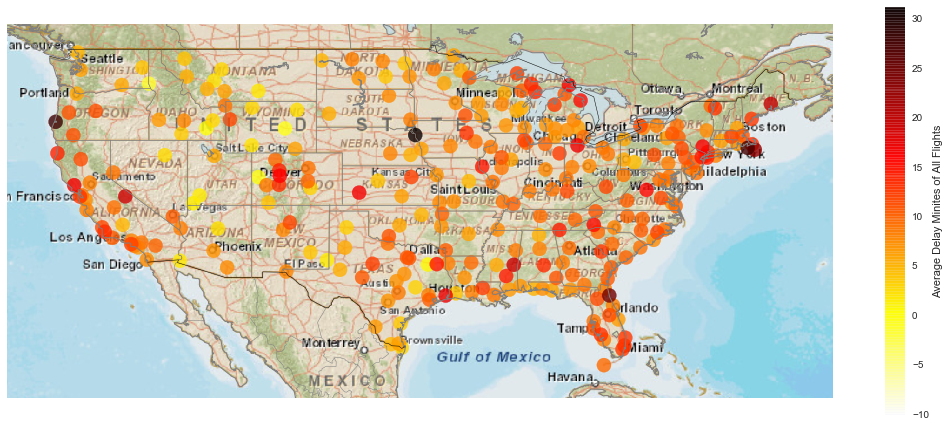

In [257]:
# continental US
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = avr_delay['LATITUDE'].values
lon = avr_delay['LONGITUDE'].values
colors = avr_delay['all_avr_delay'].values
m = Basemap(llcrnrlon=-128,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=51,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-96, resolution='l', epsg=4687)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=950)
m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.8, s=200)

plt.colorbar(label=r'Average Delay Minites of All Flights')
plt.clim(avr_delay['all_avr_delay'].min(), avr_delay['all_avr_delay'].max())

fig = plt.gcf()
fig.set_size_inches(18.5, 7.5)

plt.show()

In [182]:
from math import log10

# Average Delay Minutes for Delayed Flights

In [350]:
avr_delay['delay_count'].values / avr_delay['total_count'].values * 40

array([ 3.3970276 ,  3.80685794,  2.3255814 ,  2.81208936,  3.32033426,
        3.59281437,  4.27672956,  4.12698413,  3.18141197,  4.03722262,
        3.84781048,  8.84422111,  4.52198186,  4.35733443,  1.77595628,
        6.13496933,  3.82359525,  3.48148148,  2.52650177,  2.44436337,
        2.85311905,  3.41428054,  2.63574064,  3.04284465,  3.91554702,
        3.27784679,  2.75436793,  3.48111658,  3.56054531,  3.02158273,
        2.87718251,  2.04667864,  3.63200804,  2.58660508,  3.40371081,
        3.11108316,  3.28387735,  2.65417642,  3.39459013,  2.75659824,
        3.60065466,  3.50969438,  3.90079298,  4.54054054,  5.49019608,
        4.07499585,  4.52252252,  4.63872832,  3.93296089,  4.96717724,
        4.87623762,  4.02308326,  3.74844849,  3.91608392,  4.71427248,
        3.70828183,  6.24417521,  5.82807188,  3.12703583,  4.34213305,
        3.80816034,  4.25215166,  4.74136369,  4.44444444,  4.87515718,
        3.8496359 ,  4.35819381,  4.8106095 ,  4.20697792,  2.91

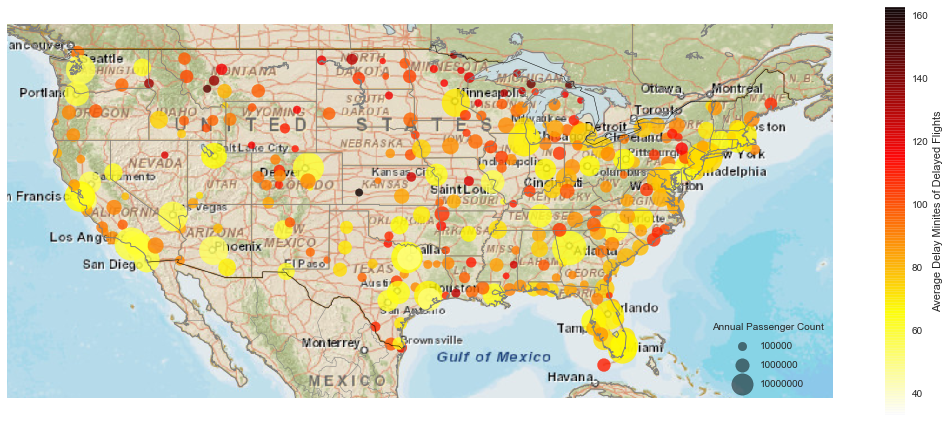

In [363]:
# continental US
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = avr_delay['LATITUDE'].values
lon = avr_delay['LONGITUDE'].values
# size = avr_delay['avr_delay'].apply(lambda x: log10(x)).values
size = avr_delay['passenger_count'].apply(lambda x: log10(x)).values
# size = avr_delay['delay_count'].values / avr_delay['total_count'].values
colors = avr_delay['avr_delay'].values
m = Basemap(llcrnrlon=-128,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=51,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-96, resolution='l', epsg=4687)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=950)
m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.8, s= 2.5 ** size)

plt.colorbar(label=r'Average Delay Minites of Delayed Flights')
# plt.clim(log10(avr_delay['avr_delay'].min()), log10(avr_delay['avr_delay'].max()))
plt.clim(avr_delay['avr_delay'].min(), avr_delay['avr_delay'].max())

# make legend with dummy points
for a in [50000, 500000, 5000000]:
    plt.scatter([], [], c='k', alpha=0.5, s=2.5 ** log10(a),
                label=str(2*a))
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower right', title='Annual Passenger Count');


fig = plt.gcf()
fig.set_size_inches(18.5, 7.5)

plt.show()

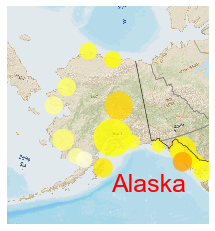

In [364]:
# Alaska
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
# a = plt.axes([.7, .1, .2, .2])
lat = avr_delay['LATITUDE'].values
lon = avr_delay['LONGITUDE'].values
size = avr_delay['passenger_count'].apply(lambda x: log10(x)).values
colors = avr_delay['avr_delay'].values
# plt.figure(edgecolor='r', linewidth=2)
m = Basemap(llcrnrlon=-170,llcrnrlat=50,urcrnrlon=-110,urcrnrlat=72,
        projection='lcc',lat_1=59,lat_2=66,lon_0=-142, resolution='l', epsg=2964)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=950)
# m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.8, s= 2.5 ** size * 4)
ax_2 = plt.gca()
ax_2.text(.7,.15,'Alaska',
        horizontalalignment='center',
        transform=ax_2.transAxes, color='red', fontsize=25)
# plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
fig_2 = plt.gcf()


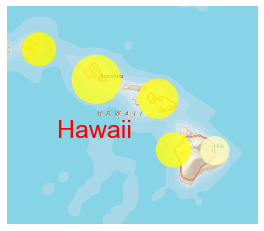

In [365]:
# Hawaii
# df_hawaii = delay_percentage[delay_percentage['STATE'] == 'Hawaii']
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = avr_delay['LATITUDE'].values
lon = avr_delay['LONGITUDE'].values
size = avr_delay['passenger_count'].apply(lambda x: log10(x)).values
colors = avr_delay['avr_delay'].values
m = Basemap(llcrnrlon=-160,llcrnrlat=18,urcrnrlon=-154,urcrnrlat=23,
        projection='lcc',lat_1=19.5,lat_2=22,lon_0=-156, resolution='l', epsg=2782)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=500)
# m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.8, s= 2.5 ** size * 4)
ax_3 = plt.gca()
ax_3.text(.35,.4,'Hawaii',
        horizontalalignment='center',
        transform=ax_3.transAxes, color='red', fontsize=25)
fig_3 = plt.gcf()

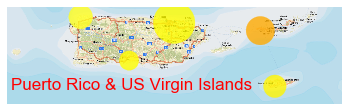

In [366]:
# Puerto Rico & US Virgin Islands
# df_pr = delay_percentage[(delay_percentage['STATE'] == 'Puerto Rico') | (delay_percentage['STATE'] == 'United States Virgin Islands')]
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = avr_delay['LATITUDE'].values
lon = avr_delay['LONGITUDE'].values
colors = avr_delay['avr_delay'].values
size = avr_delay['passenger_count'].apply(lambda x: log10(x)).values
m = Basemap(llcrnrlon=-68,llcrnrlat=17.5,urcrnrlon=-64,urcrnrlat=18.6,
        projection='lcc',lat_1=18,lat_2=18.5,lon_0=-66, resolution='l', epsg=2866)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=1000)
# m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.8, s=2.5 ** size * 4)
ax_4 = plt.gca()
ax_4.text(.37,.15,'Puerto Rico & US Virgin Islands',
        horizontalalignment='center',
        transform=ax_4.transAxes, color='red', fontsize=17)
fig_4 = plt.gcf()

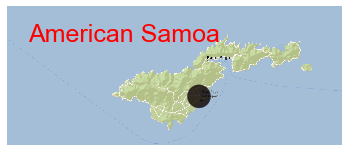

In [369]:
# American Samoa
# df_as = delay_percentage[delay_percentage['STATE'] == 'American Samoa']
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = avr_delay['LATITUDE'].values
lon = avr_delay['LONGITUDE'].values
colors = avr_delay['avr_delay'].values
size = avr_delay['passenger_count'].apply(lambda x: log10(x)).values
m = Basemap(llcrnrlon=-171,llcrnrlat=-14.4,urcrnrlon=-170.5,urcrnrlat=-14.2,
        projection='lcc',lat_1=-14.4,lat_2=-14.2,lon_0=-170.75, resolution='l', epsg=3102)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=1000)
# m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.8, s=2.5 ** size * 100 / 16)
ax_5 = plt.gca()
ax_5.text(.35,.75,'American Samoa',
        horizontalalignment='center',
        transform=ax_5.transAxes, color='red', fontsize=25)
fig_5 = plt.gcf()

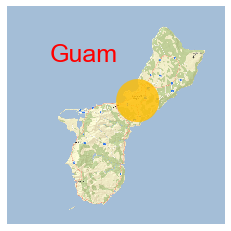

In [370]:
# Guam
# reference: https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
lat = avr_delay['LATITUDE'].values
lon = avr_delay['LONGITUDE'].values
colors = avr_delay['avr_delay'].values
size = avr_delay['passenger_count'].apply(lambda x: log10(x)).values
m = Basemap(llcrnrlon=144.5,llcrnrlat=13.2,urcrnrlon=145,urcrnrlat=13.7,
        projection='lcc',lat_1=13.3,lat_2=13.6,lon_0=144.75, resolution='l', epsg=4675)
# m = Basemap(width=12000000,height=9000000,
#             rsphere=(6378137.00,6356752.3142),\
#             resolution='l',area_thresh=1000.,projection='lcc',\
#             lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.shadedrelief()
# m.bluemarble()
m.arcgisimage(service="ESRI_StreetMap_World_2D", xpixels=1000)
# m.drawcoastlines(color='gray')
m.drawcountries(color='black')
m.drawstates(color='grey')
m.scatter(lon, lat, latlon=True,
      c=colors, cmap=plt.cm.hot_r, alpha=0.8, s=2.5 ** size * 100 / 16)
ax_6 = plt.gca()
ax_6.text(.35,.75,'Guam',
        horizontalalignment='center',
        transform=ax_6.transAxes, color='red', fontsize=25)
fig_6 = plt.gcf()

In [43]:
pd.Series(statenames).unique()

array(['West Virginia', 'Illinois', 'Maryland', 'Idaho', 'Vermont',
       'Connecticut', 'New Mexico', 'New Jersey', 'Nebraska',
       'Pennsylvania', 'Georgia', 'Colorado', 'South Carolina',
       'Oklahoma', 'North Dakota', 'Kentucky', 'Guam', 'Nevada', 'Alaska',
       'Arkansas', 'Kansas', 'South Dakota', 'Virginia', 'Iowa',
       'Arizona', 'Rhode Island', 'New Hampshire', 'North Carolina',
       'Delaware', 'California', 'Wisconsin', 'Oregon', 'Washington',
       'Louisiana', 'Utah', 'Ohio', 'Texas', 'Tennessee',
       'Commonwealth of the Northern Mariana Islands', 'New York',
       'Maine', 'American Samoa', 'Michigan', 'Montana', 'Indiana',
       'Puerto Rico', 'Massachusetts', 'District of Columbia', 'Wyoming',
       'Mississippi', 'Florida', 'Hawaii', 'Minnesota', 'Alabama',
       'Missouri', 'United States Virgin Islands'], dtype=object)

In [79]:
delay_percentage.STATE.unique()

array(['Pennsylvania', 'Texas', 'New Mexico', 'South Dakota', 'Georgia',
       'Massachusetts', 'California', 'New Jersey', 'Alaska', 'Louisiana',
       'New York', 'Iowa', 'Michigan', 'Colorado', 'Wisconsin',
       'North Carolina', 'Connecticut', 'Maine', 'Alabama', 'Montana',
       'North Dakota', 'Minnesota', 'Washington', 'Illinois', 'Tennessee',
       'Idaho', 'Puerto Rico', 'Vermont', 'Maryland', 'South Carolina',
       'Ohio', 'Utah', 'Missouri', 'Virginia', 'West Virginia', 'Wyoming',
       'Kentucky', 'Florida', 'Nevada', 'Oregon', 'Indiana', 'Arizona',
       'Arkansas', 'Kansas', 'Mississippi', 'Nebraska',
       'Commonwealth of the Northern Mariana Islands', 'Hawaii',
       'Oklahoma', 'New Hampshire', 'American Samoa', 'Rhode Island',
       'United States Virgin Islands'], dtype=object)

1

In [54]:
list(map(lambda x: (x[0] + 2, x[1]-2), a))
# lambda kv: (-kv[1], kv[0])

[(3, 0), (6, 6)]

In [41]:
enumerate(m.states)

In [40]:
statenames

AttributeError: 'list' object has no attribute 'unique'

In [6]:
stations_df.head()

WBAN  LATITUDE  LONGITUDE IATA
0   398  18.00000  -66.55000  PSE
1  3017  39.83280 -104.65750  DEN
2  3102  34.05611 -117.60028  ONT
3  3103  35.14410 -111.66630  FLG
4  3145  32.65000 -114.61667  YUM

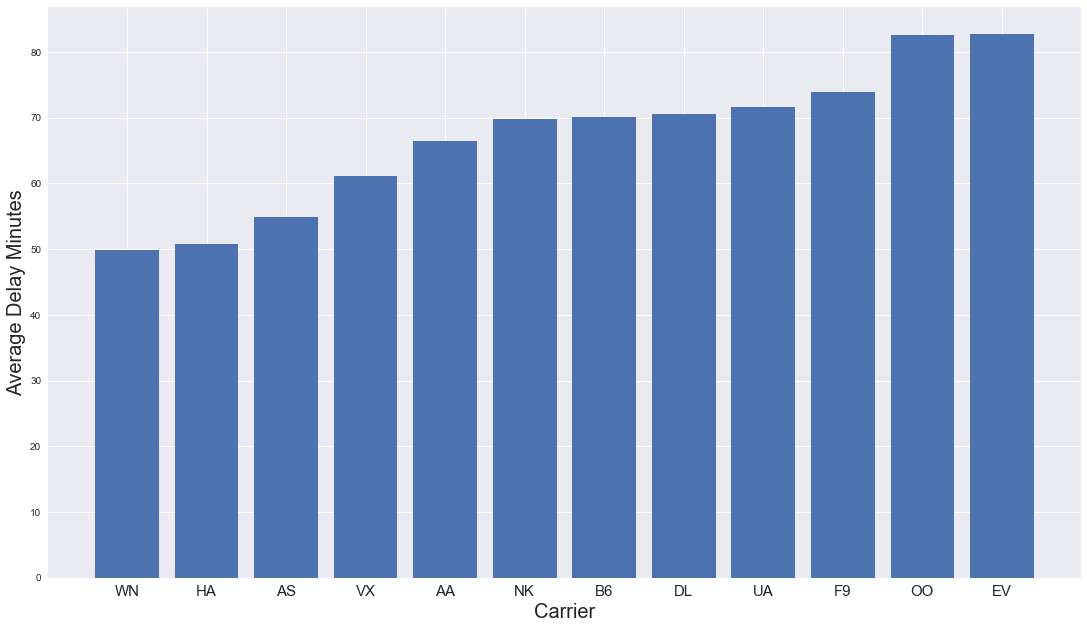

In [108]:
delayed_flight_carrier = delayed_flight.groupby('OP_CARRIER').DEP_DELAY.mean().sort_values()
plt.bar(delayed_flight_carrier.index, delayed_flight_carrier.values)
plt.xticks(delayed_flight_carrier.index, fontsize=15)
plt.xlabel('Carrier', fontsize=20)
plt.ylabel('Average Delay Minutes', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
df[(df['TAIL_NUM'] != 'PLANET') & (df['TAIL_NUM'] != 'N101NK') & (df['TAIL_NUM'] != 'N999FR') & (df['TAIL_NUM'] != 'N700TA') & (df['TAIL_NUM'] != 'N187SW') & (df['TAIL_NUM'] != 'N399FR')].shape

In [ ]:
df['ARR_DELAY_GROUP'].head()

In [ ]:
% matplotlib inline
# plt.scatter(df['ARR_DELAY_GROUP'], df['DISTANCE'], s=0.1, alpha=0.3)
data = pd.concat([df['DEP_DELAY_GROUP'], df['DISTANCE_GROUP']], axis=1)
sns.jointplot(x='DEP_DELAY_GROUP', y='DISTANCE_GROUP', data=data.loc[:1000], kind="kde")

In [ ]:
% matplotlib inline
# plt.scatter(df['ARR_DELAY_GROUP'], df['DISTANCE'], s=0.1, alpha=0.3)
data = pd.concat([df['DEP_DELAY_GROUP'], df['DEP_TIME_BLK'].apply(lambda x: int(x[:2]))], axis=1)
sns.jointplot(x='DEP_DELAY_GROUP', y='DEP_TIME_BLK', data=data.loc[:10000], kind="kde")

In [ ]:
df['DEP_TIME_BLK']

In [ ]:
data

In [ ]:
uniform_data = np.random.rand(10, 12)

In [ ]:
uniform_data